# MOSCOW REAL ESTATE PRICES
**_Doing to houses & apartments what we did to cars_**
### Data Science 410 BB
#### University of Washington Professional & Continuing Education
#### FINAL PROJECT
#### Leo Salemann, 3/10/18

# INTRODUCTION

Our dataset comes from a [Kaggle competition to predict real Moscow esate prices](https://www.kaggle.com/c/sberbank-russian-housing-market). I first encountered this data in a [team project](https://www.slideshare.net/LeoSalemann/predicting-moscow-real-estate-prices-with-azure-machine-learning) for [UW PCE Big Data Technologies - Introduciton to Data Engineering](https://www.pce.uw.edu/courses/introduction-to-data-engineering). We used [Microsoft Azure Machine Learning Studio](https://gallery.cortanaintelligence.com/Experiment/D-Hawks-Big-Data-Project-Leo-RevS) to look at multiple approaches to feature engineering, and try multiple machine learning models simultaneosly. For this project, we'll extract realestate data from Azure ML Studio, after cleaning but before any Azure ML modeling.  We'll then do our own feature analysis in Jupyter Notebook with R.

The [original kaggle datasets](https://www.kaggle.com/c/sberbank-russian-housing-market/data) consisted of two tables: Real Estate Transactions and Macro Economics. The Real Estate Transactions table includes price, timestamp, year built, property descriptors such as  square footage, number of floors, condition, etc. and neighborhood descriptors such as nearby transportation, industry, population demographics. 

Azure ML Studio Summary
1. Start with the original 30,471 rows and 292 columns
1. Select 64 columns to work with.
1. Set a bunch of numeric data to floating point, integer, category
1. Clean missing data
1. Apply SQL Transofmation (see below)
1. Normalize non-categorical rows


Cleaning missing data

|Field                         |Set To   |Rows Affected|
|------------------------------|---------|-------------|
|build_year                    |1979     |13,605       |
|life_sq (living space, m$^2$) |30       | 6,383       |
|floor (level above ground)    |7        |   167       |
|num_room                      |2        | 9,572       |
|kitch_sq (kitchen space m$^2$)|6        | 9,572       |
|material                      |mode\*   | 9,672       |
|state                         |MICE\*\* |0            |
|full_sq (total m$^2$)         |mode\*   |0            |
|max_floor (highest, 0=ground) |0        | 9,571       |
|metro_min_walk                |median   |    25       |
|railroad_station_walk_km      |median   |    25       |
|railroad_station_walk_min     |median   |    25       |
|metro_km_walk                 |median   |    25       |




\* replace nulls with the mode of the non-null data

\*\* [Multivariate Imputation using Chaned Equations](https://docs.microsoft.com/en-us/azure/machine-learning/studio-module-reference/clean-missing-data)

## SQL Filtering

# DATA EXPLORATION

## Load the data, have a quick look

In [1]:
# real_estate = read.csv("D-Hawks Big Data Project Leo _RevS_cleaned_sql_normed.csv")
real_estate = read.csv("D-Hawks Big Data Project Leo _RevS_cleaned_sql.csv")
dim(real_estate)
head(real_estate)
str(real_estate)

[1] 15693    64

timestamp             full_sq life_sq floor max_floor material build_year
1 4/27/2013 12:00:00 AM 73      36      17    17        1        1979      
2 5/25/2013 12:00:00 AM 53      30      10    16        1        1980      
3 5/27/2013 12:00:00 AM 41      37      13    17        1        1979      
4 5/27/2013 12:00:00 AM 77      41       2    17        6        2014      
5 5/27/2013 12:00:00 AM 45      27       6     9        1        1970      
6 5/28/2013 12:00:00 AM 38      20      15    16        1        1982      
  num_room kitch_sq state ⋯ prom_part_2000 office_count_2000 office_sqm_2000
1 2        11       3     ⋯  8.44           0                     0         
2 2         8       3     ⋯ 17.64          10                179554         
3 1         1       1     ⋯  1.45           0                     0         
4 3        12       1     ⋯  1.64           0                     0         
5 2         6       3     ⋯  0.74           0                     0         
6 1         8       3     ⋯ 21.51           4                 31280         
  prom_part_3000 office_count_3000 office_sqm_3000 prom_part_5000
1  8.28           0                     0           6.22         
2 16.69          14                529054          18.47         
3  2.01           0                     0           4.45         
4  1.98           0                     0           4.75         
5  1.99           1                 15000           8.05         
6 18.78          15                136990          11.12         
  office_count_5000 office_sqm_5000 price_doc
1  2                 138650         10100000 
2 25                 766701          9000000 
3  0                      0          4457400 
4  0                      0          7011550 
5  3                  81947          7100000 
6 83                3903973          6450000

'data.frame':	15693 obs. of  64 variables:
 $ timestamp                        : Factor w/ 636 levels "10/10/2013 12:00:00 AM",..: 335 382 387 387 387 390 390 395 416 464 ...
 $ full_sq                          : int  73 53 41 77 45 38 63 74 51 77 ...
 $ life_sq                          : int  36 30 37 41 27 20 30 46 30 50 ...
 $ floor                            : int  17 10 13 2 6 15 17 12 7 3 ...
 $ max_floor                        : int  17 16 17 17 9 16 17 24 17 5 ...
 $ material                         : int  1 1 1 6 1 1 4 1 1 2 ...
 $ build_year                       : int  1979 1980 1979 2014 1970 1982 2013 2004 2003 1957 ...
 $ num_room                         : int  2 2 1 3 2 1 2 3 2 3 ...
 $ kitch_sq                         : int  11 8 1 12 6 8 1 9 9 8 ...
 $ state                            : int  3 3 1 1 3 3 1 3 3 2 ...
 $ product_type                     : Factor w/ 2 levels "Investment","OwnerOccupier": 1 1 2 2 1 1 2 1 1 1 ...
 $ sub_area                         : Factor 

## Data Cleanups
 - **Drop NA Values**
 - **Parse the Date**
 - **Create a price per square meter**

In [2]:
real_estate = na.omit(real_estate)
dim(real_estate)
real_estate$date = as.Date(real_estate$timestamp,format='%m/%d/%Y')
real_estate$year_sold  = 
    as.numeric(format(as.Date(real_estate$timestamp,format='%m/%d/%Y'), '%Y'))
real_estate$month_sold = 
    as.numeric(format(as.Date(real_estate$timestamp,format='%m/%d/%Y'), '%m'))
real_estate$day_sold   = 
    as.numeric(format(as.Date(real_estate$timestamp,format='%m/%d/%Y'), '%d'))
real_estate$price_sqm = real_estate$price_doc/real_estate$full_sq
head(real_estate, 3)
str(real_estate)

[1] 9233   64

timestamp             full_sq life_sq floor max_floor material build_year
5 5/27/2013 12:00:00 AM 45      27       6     9        1        1970      
6 5/28/2013 12:00:00 AM 38      20      15    16        1        1982      
7 5/28/2013 12:00:00 AM 63      30      17    17        4        2013      
  num_room kitch_sq state ⋯ office_sqm_3000 prom_part_5000 office_count_5000
5 2        6        3     ⋯  15000           8.05           3               
6 1        8        3     ⋯ 136990          11.12          83               
7 2        1        1     ⋯      0           6.54           1               
  office_sqm_5000 price_doc date       year_sold month_sold day_sold price_sqm
5   81947         7100000   2013-05-27 2013      5          27       157777.78
6 3903973         6450000   2013-05-28 2013      5          28       169736.84
7   26950         5903808   2013-05-28 2013      5          28        93711.24

'data.frame':	9233 obs. of  69 variables:
 $ timestamp                        : Factor w/ 636 levels "10/10/2013 12:00:00 AM",..: 387 390 390 395 416 464 474 474 474 410 ...
 $ full_sq                          : int  45 38 63 74 51 77 52 56 31 43 ...
 $ life_sq                          : int  27 20 30 46 30 50 33 29 21 27 ...
 $ floor                            : int  6 15 17 12 7 3 13 5 5 1 ...
 $ max_floor                        : int  9 16 17 24 17 5 25 16 9 5 ...
 $ material                         : int  1 1 4 1 1 2 2 5 5 2 ...
 $ build_year                       : int  1970 1982 2013 2004 2003 1957 2004 1987 1962 1960 ...
 $ num_room                         : int  2 1 2 3 2 3 2 2 1 2 ...
 $ kitch_sq                         : int  6 8 1 9 9 8 7 10 5 5 ...
 $ state                            : int  3 3 1 3 3 2 3 2 3 2 ...
 $ product_type                     : Factor w/ 2 levels "Investment","OwnerOccupier": 1 1 2 1 1 1 1 1 1 1 ...
 $ sub_area                         : Factor w/ 126

## Density Plot for Price

Loading required package: ggplot2


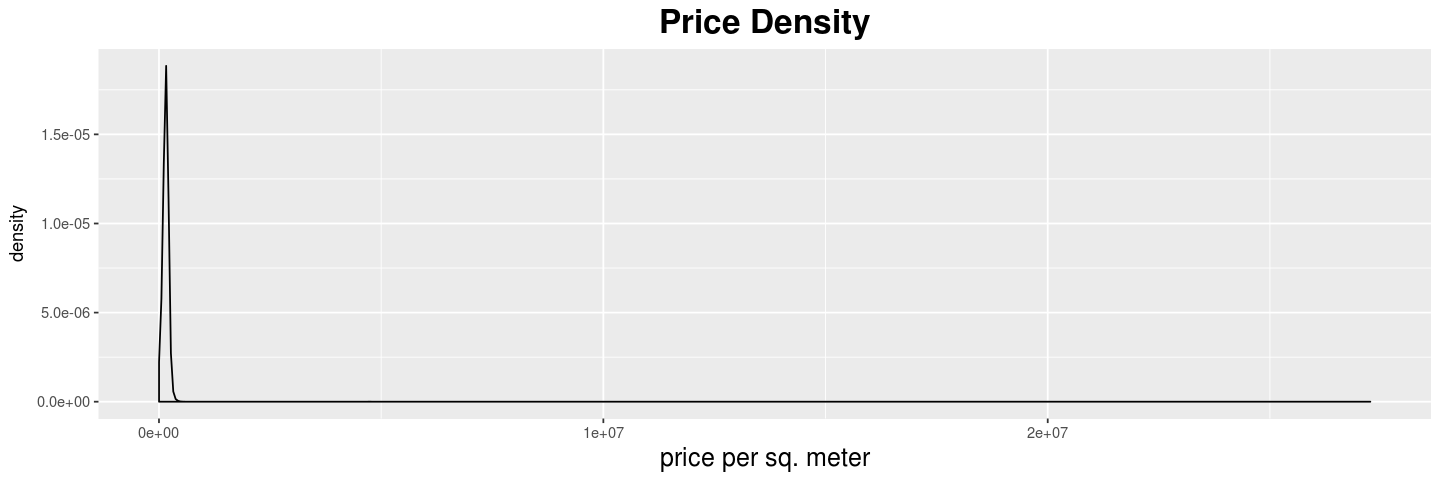

In [3]:
require(ggplot2)
options(repr.plot.width=12, repr.plot.height=4)
ggplot(real_estate, aes(price_sqm)) + 
      geom_density() + 
      xlab("price per sq. meter") + 
      ggtitle("Price Density") + 
      theme(plot.title = element_text(hjust = 0.5, size=20, face="bold"),
           axis.title.x = element_text(size=15))

## Take the log, Plot again

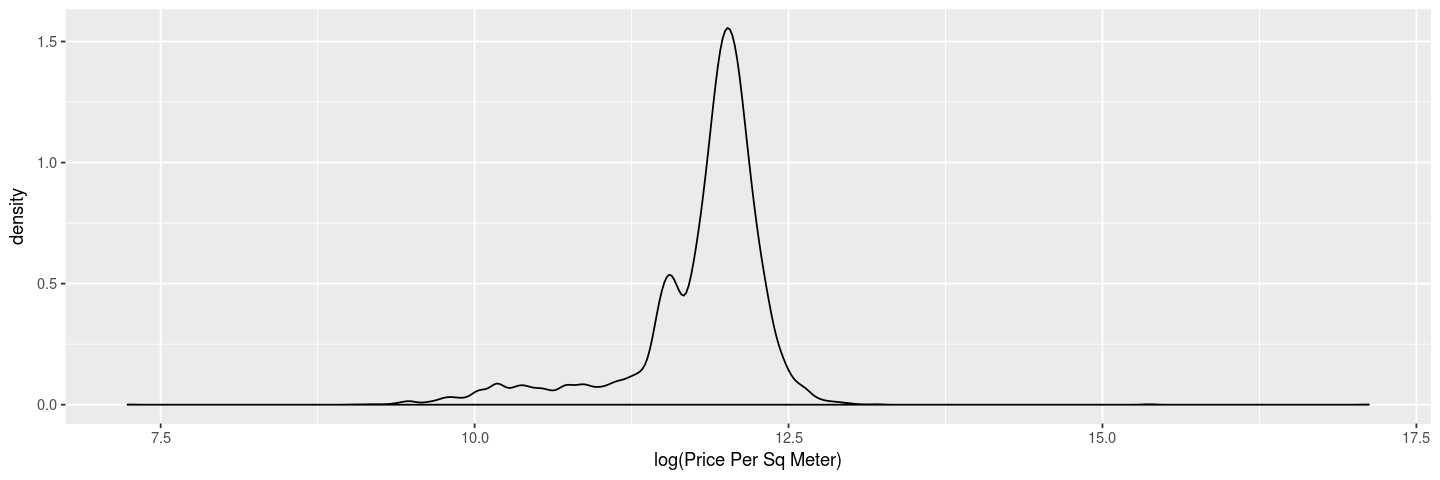

In [4]:
options(repr.plot.width=12, repr.plot.height=4)
real_estate$log.price_sqm = log(real_estate$price_sqm)
# head(real_estate)
ggplot(real_estate, aes(log.price_sqm)) + geom_density() + 
xlab('log(Price Per Sq Meter)')

## Trim the tails, Plot again

Warning message:
“Removed 837 rows containing non-finite values (stat_density).”

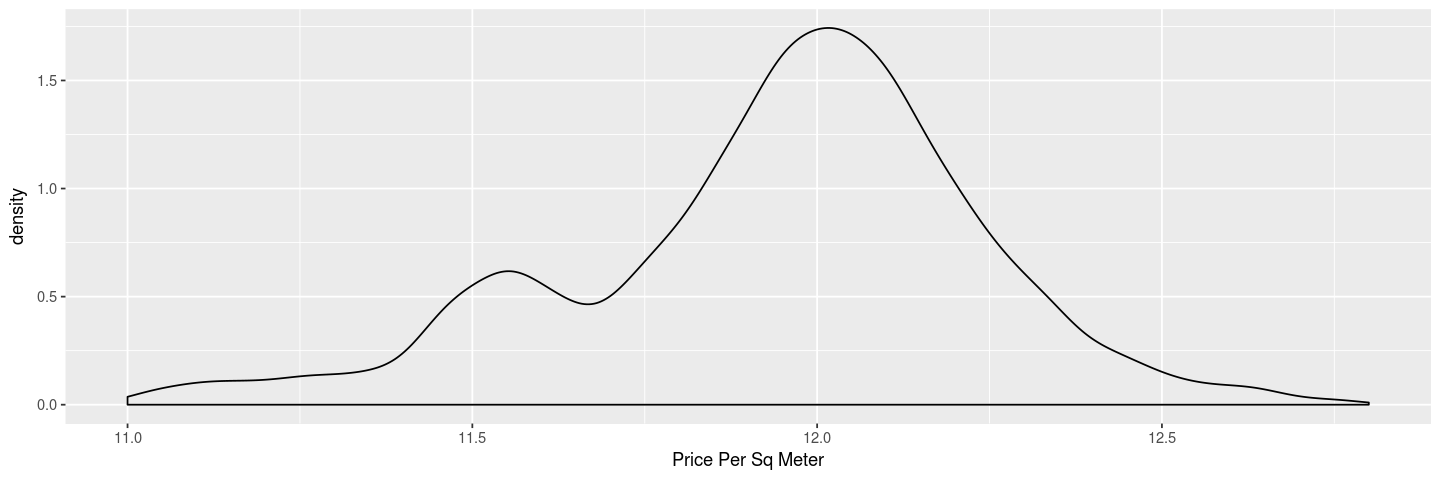

In [5]:
x_min = 11 # was 9.5
x_max = 12.8

ggplot(real_estate, aes(log.price_sqm)) + 
geom_density() + xlab('Price Per Sq Meter') + 
xlim(c(x_min, x_max)) 

## Use what we learned to trim the dataframe

In [6]:
real_estate.trimmed = real_estate[real_estate$log.price_sqm <= x_max,]
real_estate.trimmed = real_estate.trimmed[real_estate.trimmed$log.price_sqm >= x_min,]
dim(real_estate)
dim(real_estate.trimmed)
real_estate = real_estate.trimmed

[1] 9233   70

[1] 8396   70

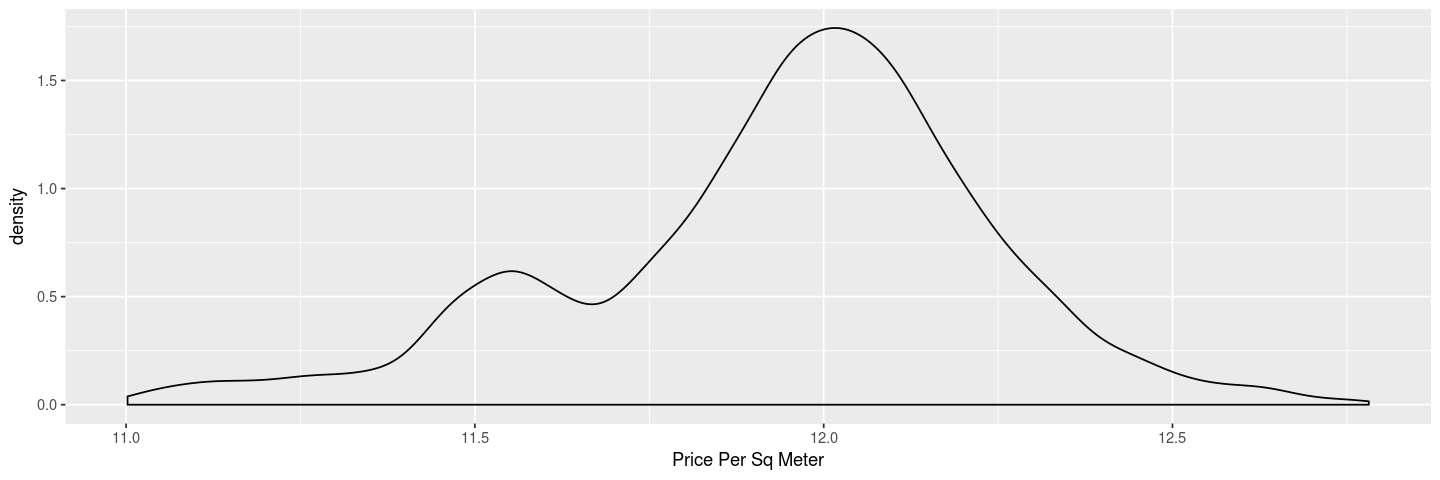

In [7]:
ggplot(real_estate, aes(log.price_sqm)) + 
geom_density() + xlab('Price Per Sq Meter')

## A Scattering of Scatterplots: The search for meaning

We've got 70 features and 9,181 oveservations. Time to walk thru the dataset looking for features that have some kind of relationship with price per square foot. As we go along, we'll keep track of features which have non-zero trendlines, or that show promise as a categorical feature for splitting data.  Basically, we're looking for regression lines (solid green) with non-zero slopes and narrow confidence intervals (dashed red).  For categoricals, we're looking for "spiky" density plots.

In [8]:
require(GGally)

plot.matrix = function(df, cols){
    options(repr.plot.width=8, repr.plot.height=8)
    ggpairs(data=df,
            columns=cols,
            upper = list(continuous = "density"),
            lower = list(continuous = "density"),
            cardinality_threshold = 130)
}

Loading required package: GGally
Warning message:
“replacing previous import by ‘utils::capture.output’ when loading ‘GGally’”Warning message:
“replacing previous import by ‘utils::head’ when loading ‘GGally’”Warning message:
“replacing previous import by ‘utils::installed.packages’ when loading ‘GGally’”Warning message:
“replacing previous import by ‘utils::str’ when loading ‘GGally’”

In [26]:
plot.violin <- function(df, xvar, title){
    options(repr.plot.width=12, repr.plot.height=4)
    ggplot(df, aes(x = factor(xvar), y = df$log.price_sqm)) +
    geom_violin(trim = TRUE, draw_quantiles = c(0.25, 0.5, 0.75)) +
    xlab(title) + ylab("log(price/sqm)") + ggtitle(title)
}

plot.violin.vert <- function(df, xvar, title){
    options(repr.plot.width=12, repr.plot.height=4)
    ggplot(df, aes(x = factor(xvar), y = df$log.price_sqm)) +
    geom_violin(trim = TRUE, draw_quantiles = c(0.25, 0.5, 0.75)) +
    xlab(title) + ylab("log(price/sqm)")+ ggtitle(title) +
    theme(axis.text.x = element_text(angle = 90, hjust = 1))
}

plot.density.2d = function(df, xvar, title){
    ggplot(df, aes(x = xvar, y = df$log.price_sqm,))+  
    geom_density2d() +
    xlab(title) + ylab("log(price/sqm)")+ ggtitle(title)
}

## Let's get started with columns 2-6

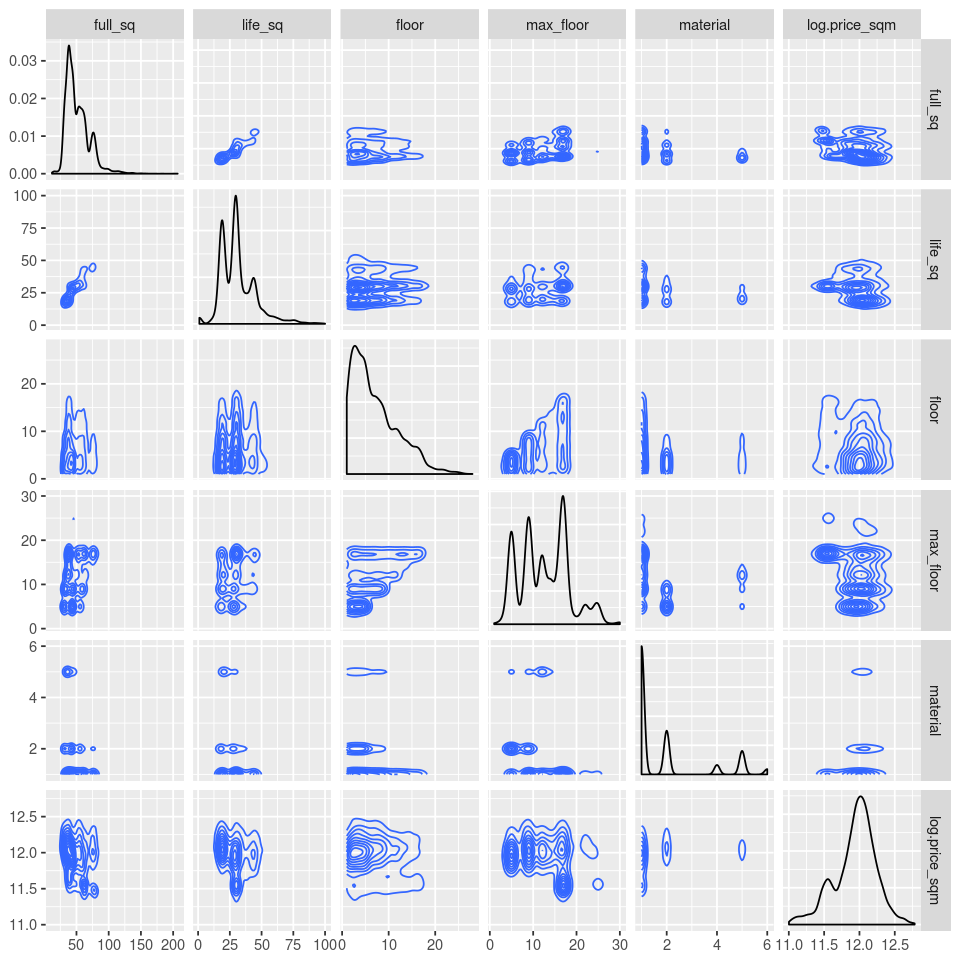

In [66]:
plot.matrix(real_estate, c(2:6,70))

Nothing very informative here, moving on.

## Next up: columns 6-11

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


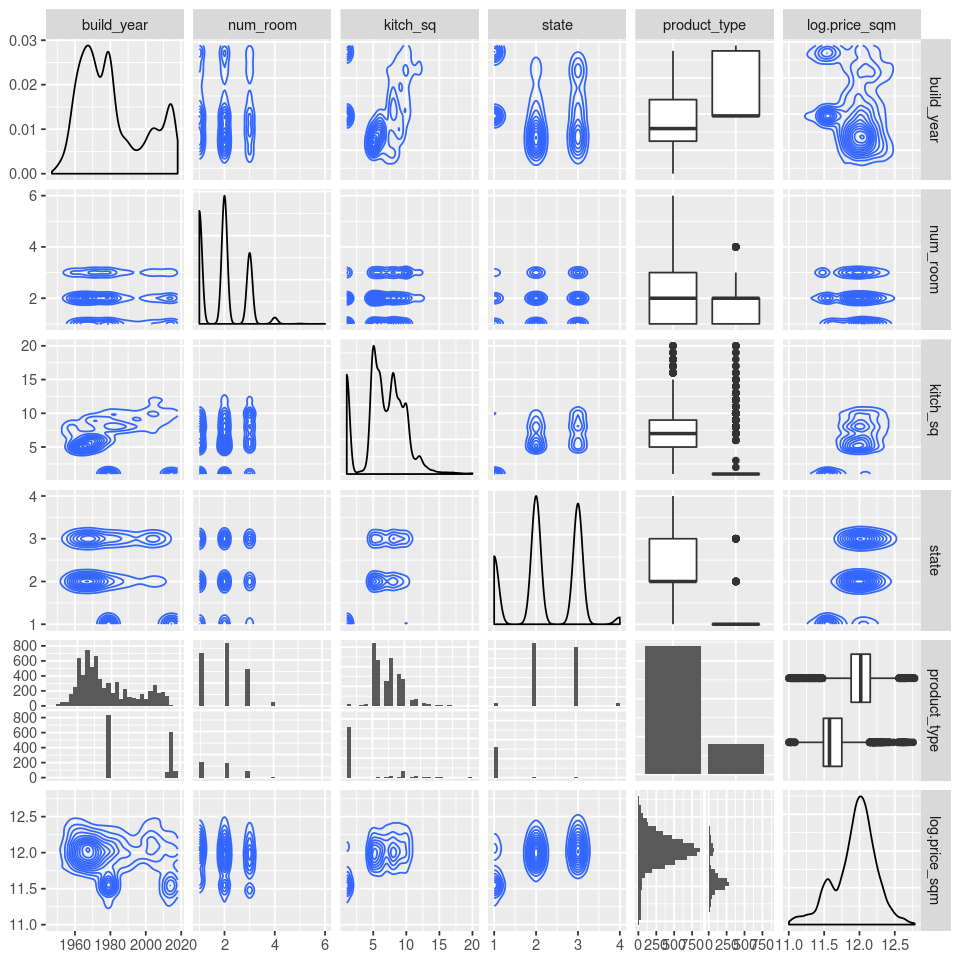

In [25]:
plot.matrix(real_estate, c(7:11,70))

Now we're getting somewhere (hopefully). **product_type** separates intwo two prices nicely. Similary, **state** clusters around one set of prices for **state = 1,** and another group for **2** and **3**. Time to start a list.

|feature       |buckets            |
|:-------------|:------------------|
|product_type  |only has 2 values  |
|state         |1, 2-3             |

**build_year** is  a little tricky. Let's look closer at that one. 

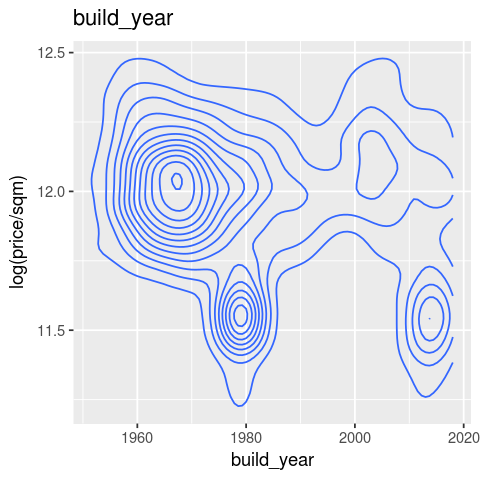

In [43]:
options(repr.plot.width=4, repr.plot.height=4)
plot.density.2d(real_estate, real_estate$build_year, "build_year")

We're basically looking for ways to draw horizontal lines across the plot to split the contours into "islands."  In this case, you can draw a line at price per sq. m = 11.75. From the vertical point of view, we can get the split we want by separating build year into one bucket for 1970-1990 as well as 2010-2020, and one for everything else.

Update our notes:

|feature       |buckets                              |
|:-------------|:------------------------------------|
|product_type  |only has 2 values                    |
|state         |1, 2-3                               |
|build_year    |1970-1990, 2010-2020, everything else|

## Next up: columns 12-16

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


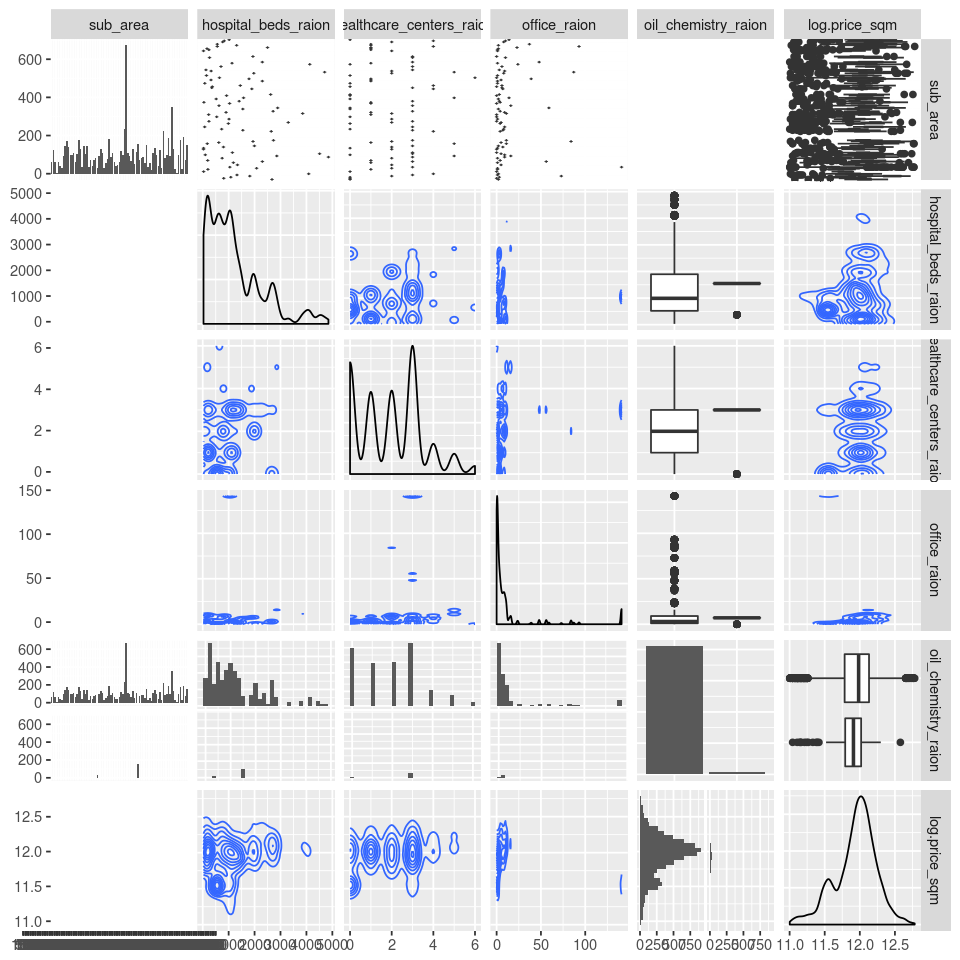

In [44]:
plot.matrix(real_estate, c(12:16,70))

Another Messy one. Need to look at **office_raion**, **health_centers_raion**, **sub_area** 

### office_raion

Looks light we might learn something if we trim **office_raion** greater than 50

Warning message:
“Removed 1207 rows containing non-finite values (stat_density2d).”

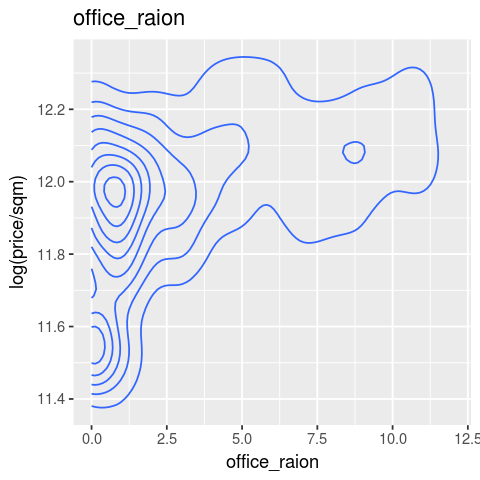

In [45]:
options(repr.plot.width=4, repr.plot.height=4)
ggplot(real_estate, aes(x = office_raion, y = real_estate$log.price_sqm,))+  
  geom_density2d() +
  xlab("office_raion") + ylab("log(price/sqm)")+ ggtitle("office_raion") + 
  xlim(c(0, 12)) 

Looks like we can bucket it by whether it's greatter or less than 5.

|feature       |buckets                              |
|:-------------|:------------------------------------|
|office_raion  |0-5, 5+                              |
|product_type  |only has 2 values                    |
|state         |1, 2-3                               |
|build_year    |1970-1990, 2010-2020, everything else|

Next-up: **health centers raion**

### health_centers_raion

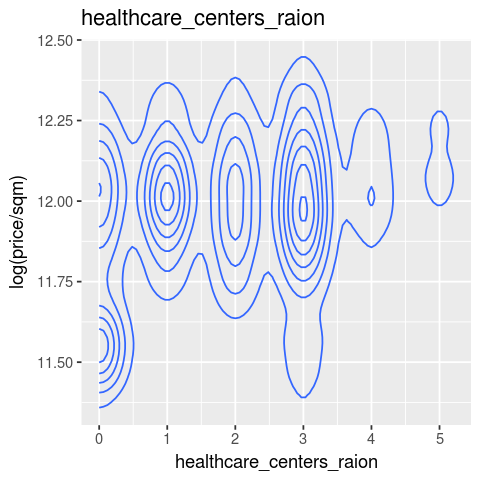

In [51]:
options(repr.plot.width=4, repr.plot.height=4)
plot.density.2d(real_estate, real_estate$healthcare_centers_raion, 
                "healthcare_centers_raion")

Too noisy; moving on.

### sub_area

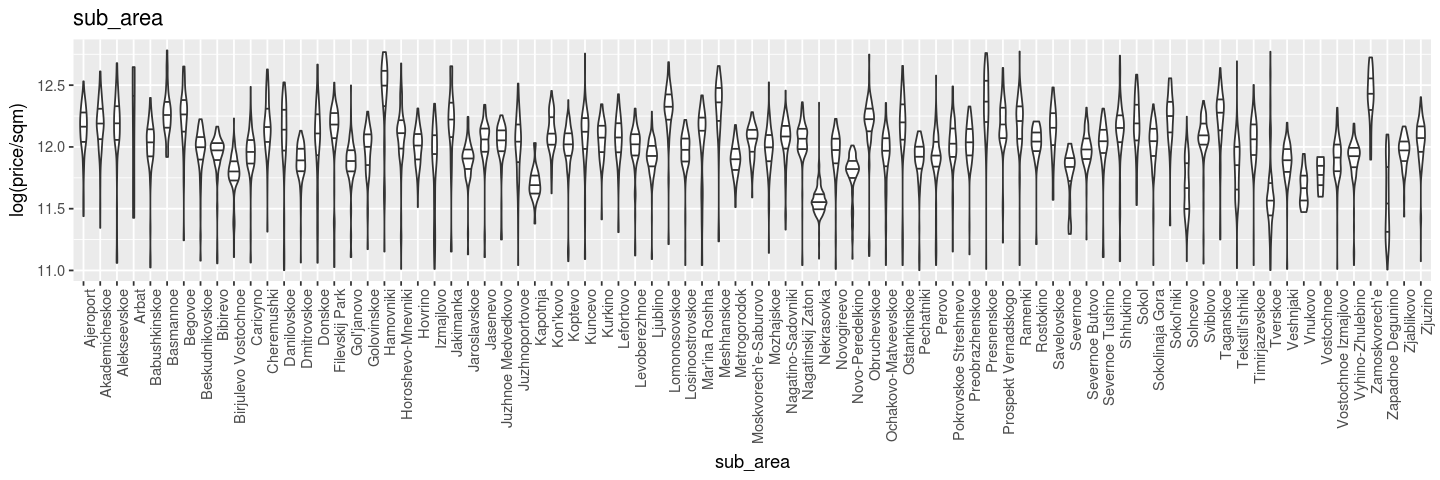

In [49]:
plot.violin.vert(real_estate, real_estate$sub_area, "sub_area")

Good thing I have bifocals. After careful examiiation, we can update the our notes as such:

|feature       |buckets                              |
|:-------------|:------------------------------------|
|sub_area      |- Kapotnja, Nekrasovka, Tverskoe, Vnukovo<br>- Hamovniki, Zamoskvorech'e, Hamovniki<br>- everything else|
|office_raion  |0-5, 5+                              |
|product_type  |only has 2 values                    |
|state         |1, 2-3                               |
|build_year    |1970-1990, 2010-2020, everything else|

## Next up: columns 17-20

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


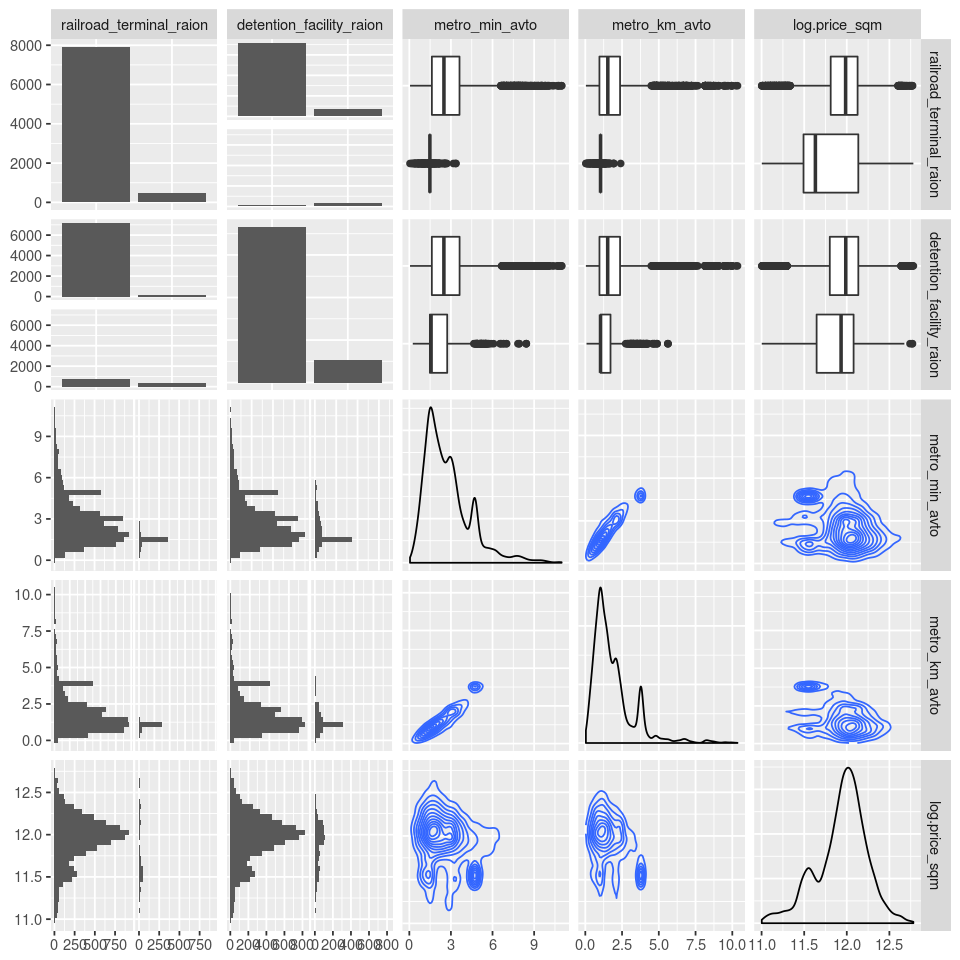

In [12]:
plot.matrix(real_estate, c(17:20,70))

**railroad_terminal_raion** looks promising in the upper-right corner (boxplots), but less so in the lower-left (overlapping histograms).  Try a violin plot for a closer look.

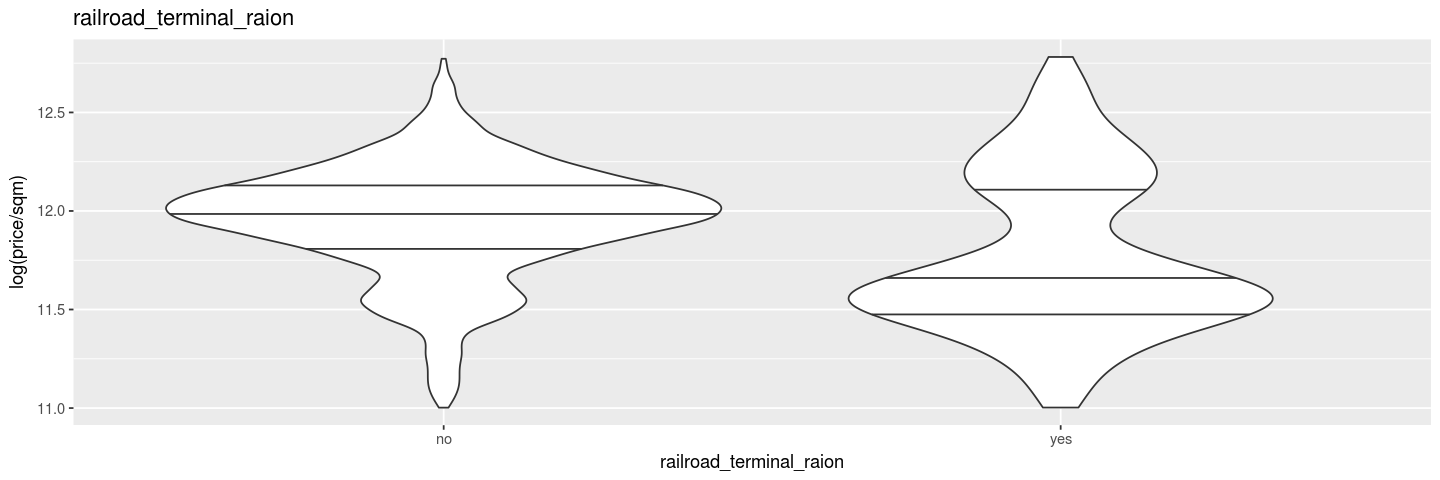

In [74]:
plot.violin(real_estate, real_estate$railroad_terminal_raion, "railroad_terminal_raion")

Mean of the no's falls within one stdev of the yes's.  Skip it.

Next up: **metro_km_avto**.  Let's look closer to find where to split it.

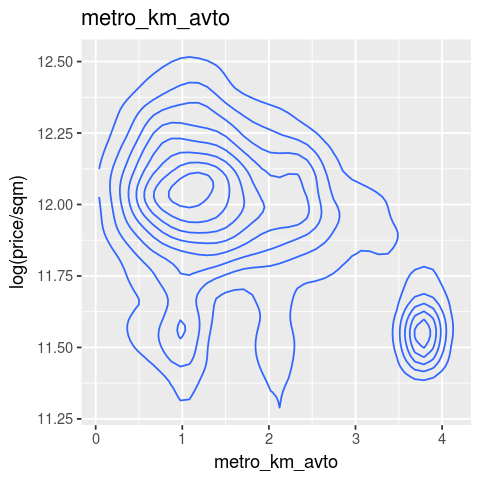

In [52]:
options(repr.plot.width=4, repr.plot.height=4)
plot.density.2d(real_estate, real_estate$metro_km_avto, "metro_km_avto")

Good place to split it is 3.25. Update our notes

|feature       |buckets                              |
|:-------------|:------------------------------------|
|metro_km_avto |0-3.25, 3.25+                        |
|sub_area      |- Kapotnja, Nekrasovka, Tverskoe, Vnukovo<br>- Hamovniki, Zamoskvorech'e, Hamovniki<br>- everything else                       |
|office_raion  |0-5, 5+                              |
|product_type  |only has 2 values                    |
|state         |1, 2-3                               |
|build_year    |1970-1990, 2010-2020, everything else|

## Next up: columns 21-25

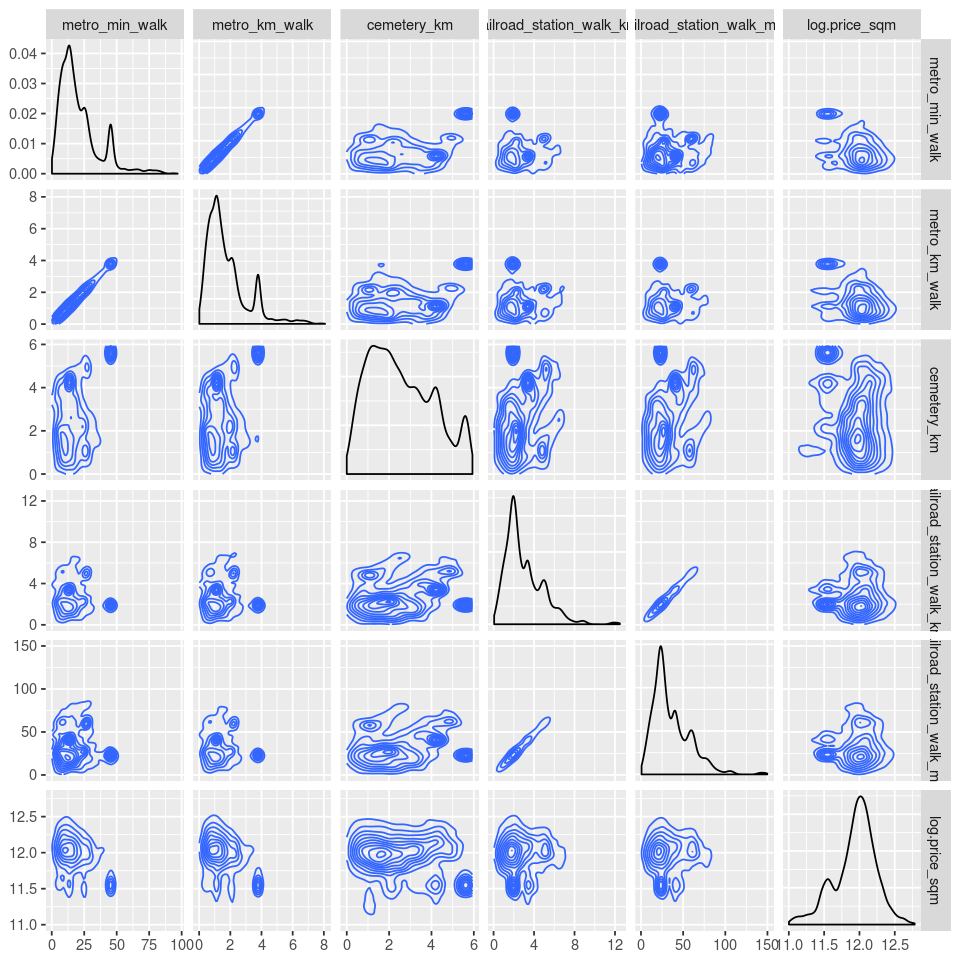

In [53]:
plot.matrix(real_estate, c(21:25,70))

Promising values are **metro_km_walk**, **cemetry_km**

|feature       |buckets                              |
|:-------------|:------------------------------------|
|metro_km_walk |0-3, 3+                              |
|cemetry_km    |0-5, 3+                              |
|metro_km_avto |0-3.25, 3.25+                        |
|sub_area      |- Kapotnja, Nekrasovka, Tverskoe, Vnukovo<br>- Hamovniki, Zamoskvorech'e, Hamovniki<br>- everything else                       |
|office_raion  |0-5, 5+                              |
|product_type  |only has 2 values                    |
|state         |1, 2-3                               |
|build_year    |1970-1990, 2010-2020, everything else|

## Next up: columns 26-30

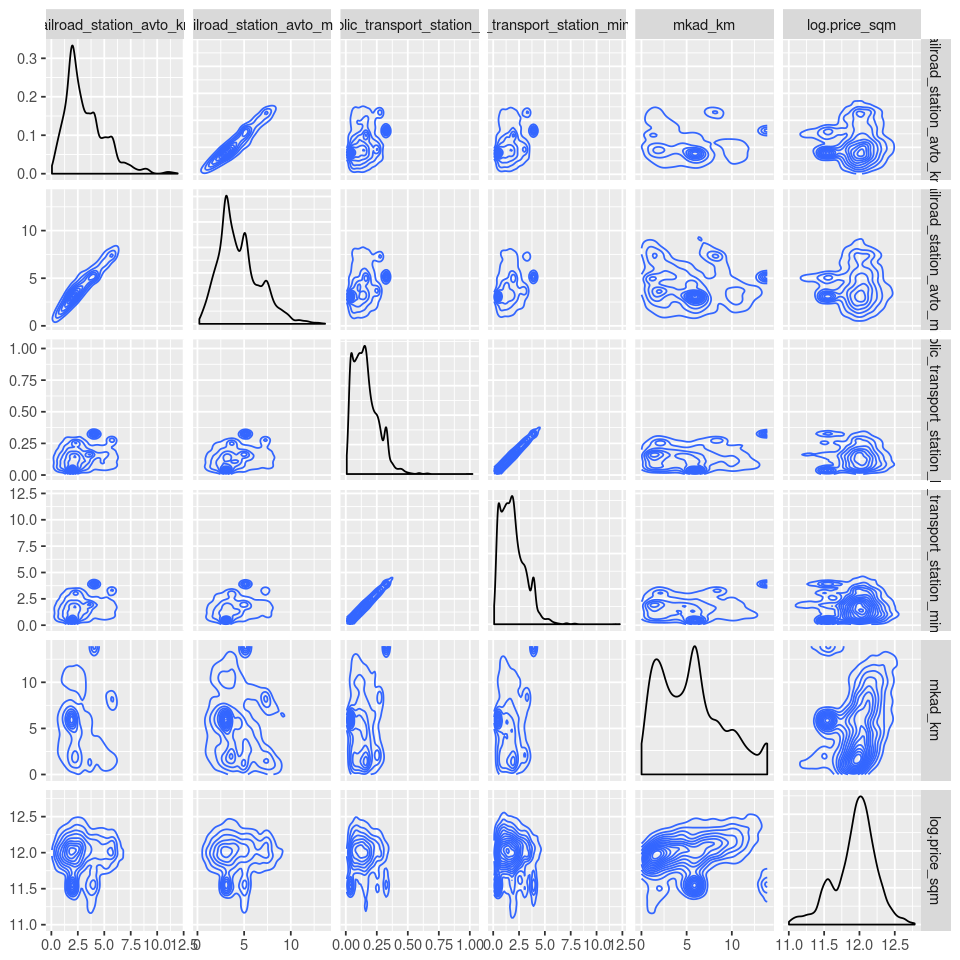

In [14]:
plot.matrix(real_estate, c(26:30,70))

Most promising is **mkad_km**. Get a closer look.

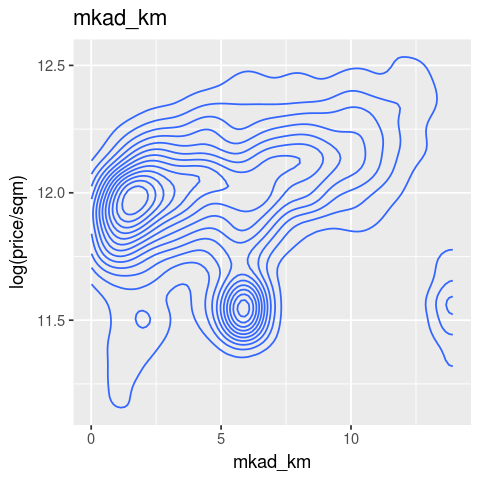

In [59]:
options(repr.plot.width=4, repr.plot.height=4)
plot.density.2d(real_estate, real_estate$mkad_km, "mkad_km")

Looks like the bucket boundaries should be 4, 7.5, 12.5

|feature       |buckets                              |
|:-------------|:------------------------------------|
|mkad_km       |0-4, 4-7.5, 7.5-12.5, 12.5+          |
|metro_km_walk |0-3, 3+                              |
|cemetry_km    |0-5, 3+                              |
|metro_km_avto |0-3.25, 3.25+                        |
|sub_area      |- Kapotnja, Nekrasovka, Tverskoe, Vnukovo<br>- Hamovniki, Zamoskvorech'e, Hamovniki<br>- everything else                       |
|office_raion  |0-5, 5+                              |
|product_type  |only has 2 values                    |
|state         |1, 2-3                               |
|build_year    |1970-1990, 2010-2020, everything else|

## Next up: columns 31-35

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


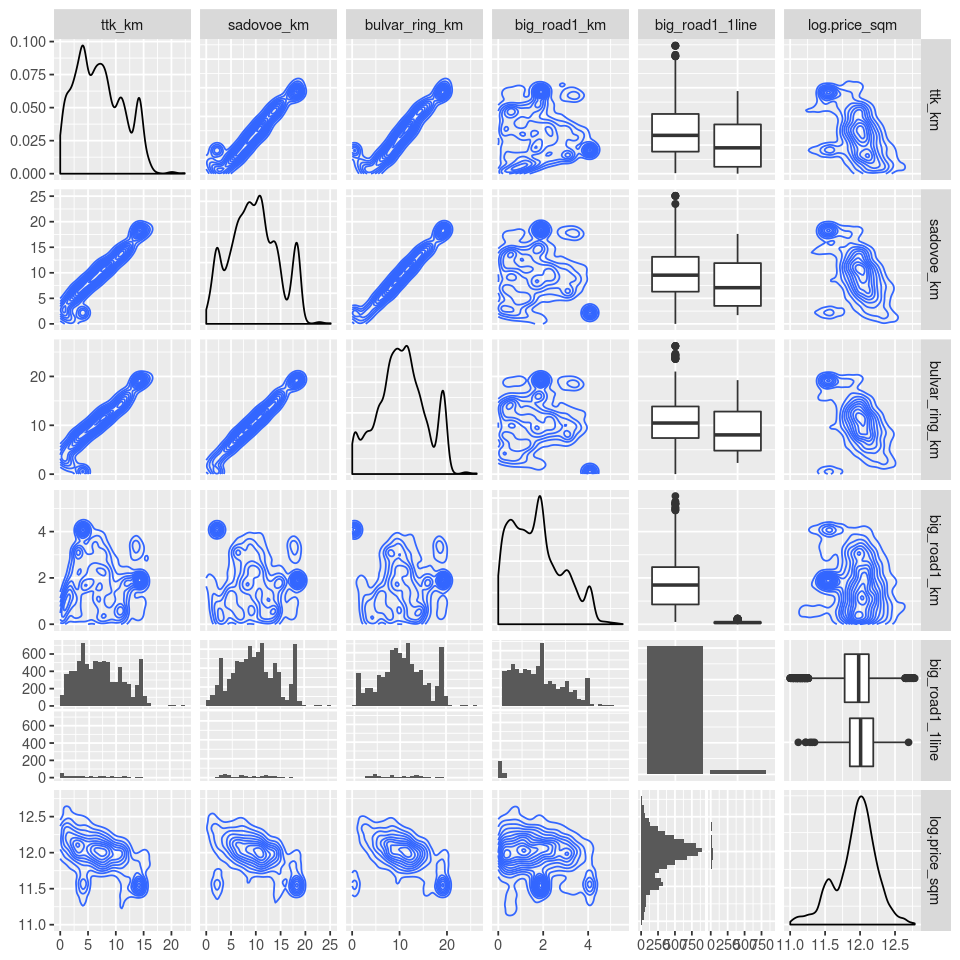

In [15]:
plot.matrix(real_estate, c(31:35,70))

**bulvar_ring_km** can have bucket boundaries at 5 and 15

**big_road1_km** could be bucketized, but we need a closer look

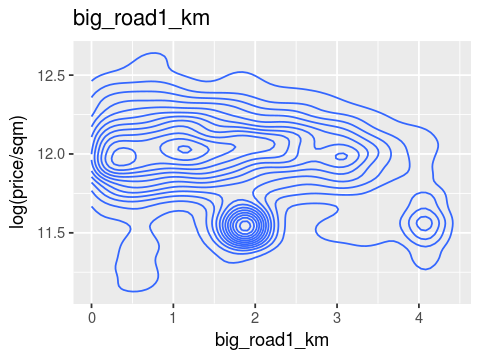

In [68]:
options(repr.plot.width=4, repr.plot.height=3)
plot.density.2d(real_estate, real_estate$big_road1_km, "big_road1_km")

**big_road1_km** can have bucket boundaries at 0.8, 1.5, 2.5, 3.75. Update the list

|feature       |buckets                                  |
|:-------------|:----------------------------------------|
|big_road1_km  |0-0.8, 0.8-1.5, 1.5-2.5, 2.5-3.75, 3.75+ |
|bulvar_ring_km|0-5, 5-15, 15+                           |
|mkad_km       |0-4, 4-7.5, 7.5-12.5, 12.5+              |
|metro_km_walk |0-3, 3+                                  |
|cemetry_km    |0-5, 3+                                  |
|metro_km_avto |0-3.25, 3.25+                            |
|sub_area      |- Kapotnja, Nekrasovka, Tverskoe, Vnukovo<br>- Hamovniki, Zamoskvorech'e, Hamovniki<br>- everything else                           |
|office_raion  |0-5, 5+                                  |
|product_type  |only has 2 values                        |
|state         |1, 2-3                                   |
|build_year    |1970-1990, 2010-2020, everything else    |

## Next up: columns 36-40

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


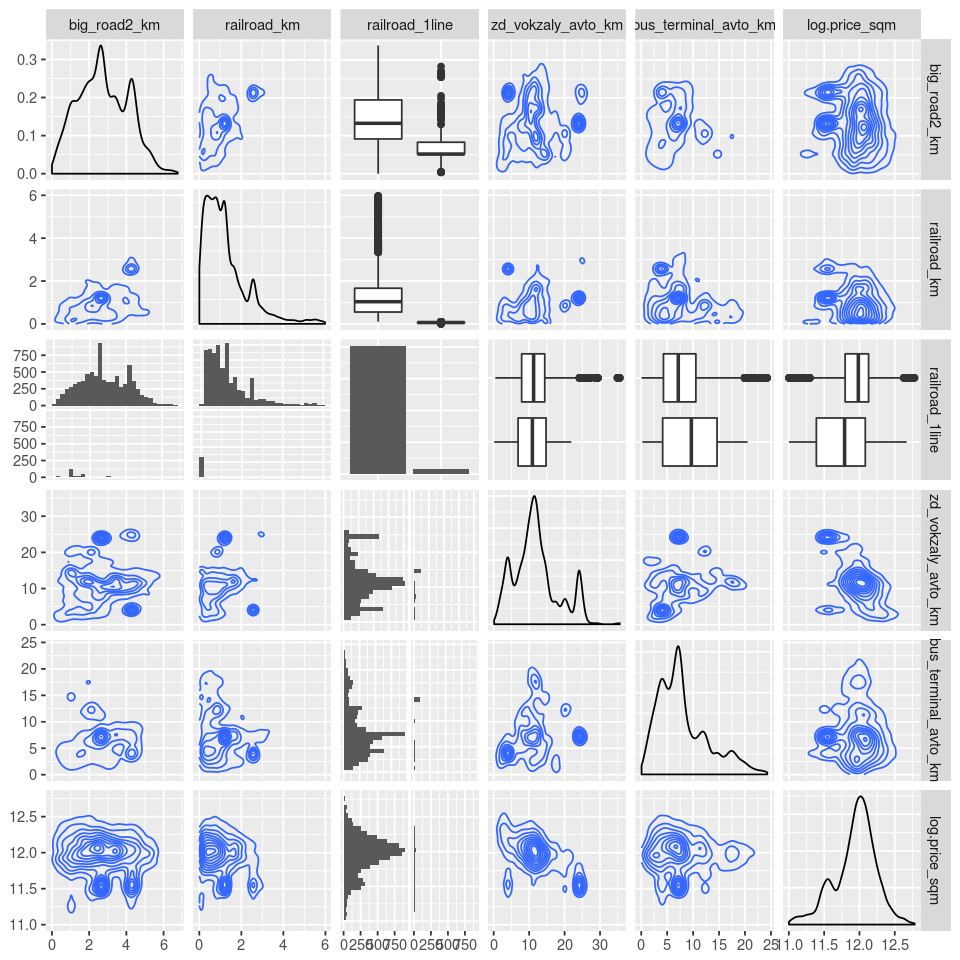

In [16]:
plot.matrix(real_estate, c(36:40,70))

**zd_vokzaly_avto_km** splits nicely into 3 pieces.  Let's get a closer look.

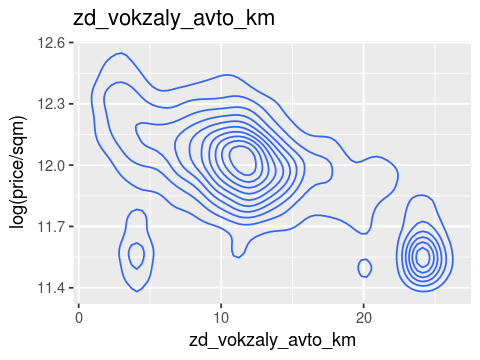

In [71]:
options(repr.plot.width=4, repr.plot.height=3)
plot.density.2d(real_estate, real_estate$zd_vokzaly_avto_km, "zd_vokzaly_avto_km")

Looks like the boundaries should be at 7.5 and 17.5

|feature            |buckets                                  |
|:------------------|:----------------------------------------|
|zd_vokzaly_avto_km |0-7.5, 7.5-17.5, 17.5+                   |
|big_road1_km       |0-0.8, 0.8-1.5, 1.5-2.5, 2.5-3.75, 3.75+ |
|bulvar_ring_km     |0-5, 5-15, 15+                           |
|mkad_km            |0-4, 4-7.5, 7.5-12.5, 12.5+              |
|metro_km_walk      |0-3, 3+                                  |
|cemetry_km         |0-5, 3+                                  |
|metro_km_avto      |0-3.25, 3.25+                            |
|sub_area           |- Kapotnja, Nekrasovka, Tverskoe, Vnukovo<br>- Hamovniki, Zamoskvorech'e, Hamovniki<br>- everything else                |
|office_raion       |0-5, 5+                                  |
|product_type       |only has 2 values                        |
|state              |1, 2-3                                   |
|build_year         |1970-1990, 2010-2020, everything else    |

## Next up: columns 41-45

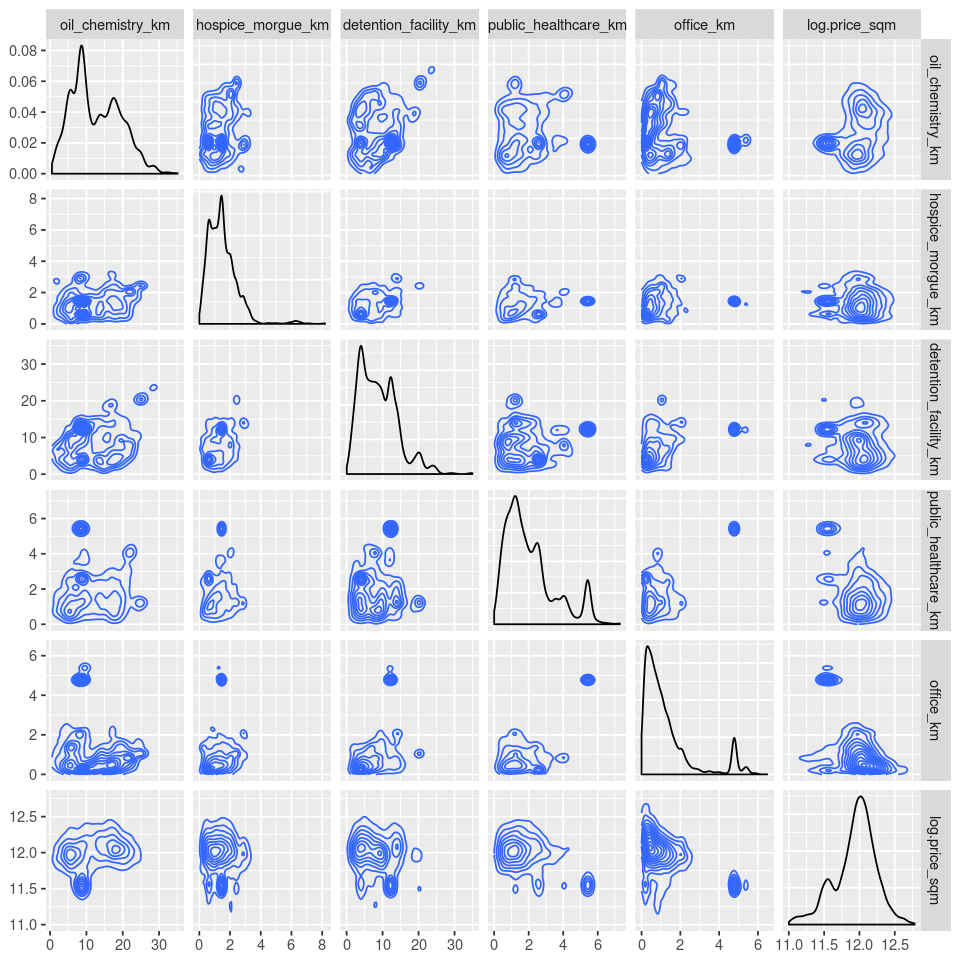

In [17]:
plot.matrix(real_estate, c(41:45,70))

Promising values are **office_km** and **public_healthcare_km** 

|feature             |buckets                                  |
|:-------------------|:----------------------------------------|
|office_km           |0-4, 4+                                  |
|public_healthcare_km|0-4.5, 4.5+                              |
|zd_vokzaly_avto_km  |0-7.5, 7.5-17.5, 17.5+                   |
|big_road1_km        |0-0.8, 0.8-1.5, 1.5-2.5, 2.5-3.75, 3.75+ |
|bulvar_ring_km      |0-5, 5-15, 15+                           |
|mkad_km             |0-4, 4-7.5, 7.5-12.5, 12.5+              |
|metro_km_walk       |0-3, 3+                                  |
|cemetry_km          |0-5, 3+                                  |
|metro_km_avto       |0-3.25, 3.25+                            |
|sub_area            |- Kapotnja, Nekrasovka, Tverskoe, Vnukovo<br>- Hamovniki, Zamoskvorech'e, Hamovniki<br>- everything else                 |
|office_raion        |0-5, 5+                                  |
|product_type        |only has 2 values                        |
|state               |1, 2-3                                   |
|build_year          |1970-1990, 2010-2020, everything else    |

## Next up: columns 46-50

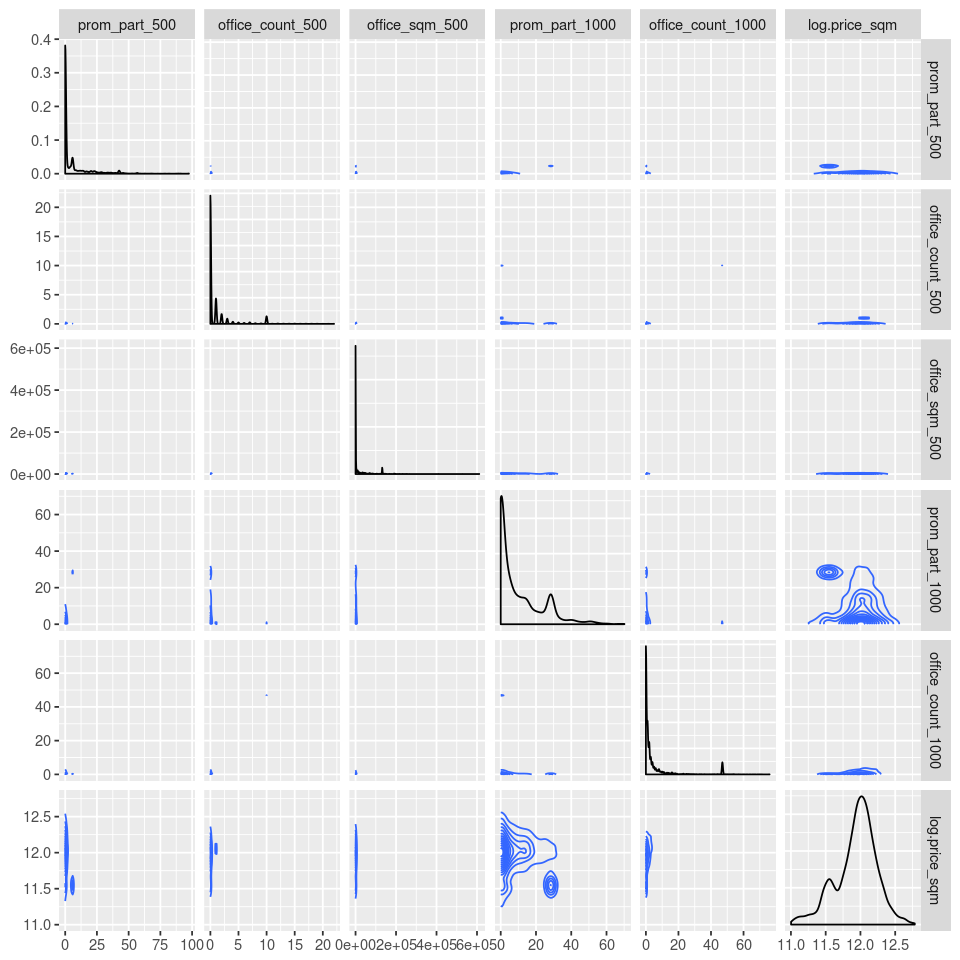

In [18]:
plot.matrix(real_estate, c(46:50,70))

Going to need to do some trimming before we can see anything

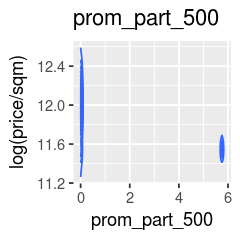

In [103]:
options(repr.plot.width=2, repr.plot.height=2)

real_estate.trim1= real_estate[real_estate$prom_part_500 <= 10,]
plot.density.2d(real_estate.trim1, real_estate.trim1$prom_part_500, "prom_part_500")

Nope, too flat.  Next:

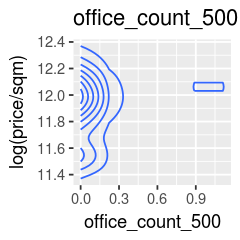

In [97]:
real_estate.trim2= real_estate[real_estate$office_count_500 <= 2,]
plot.density.2d(real_estate.trim1, real_estate.trim1$office_count_500, "office_count_500")

Nope, not enough uniqueness long the price axis.  Next:

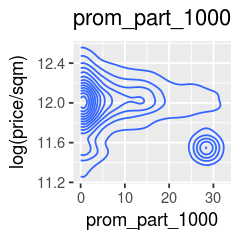

In [104]:
real_estate.trim4= real_estate[real_estate$prom_part_1000 <= 7,]
plot.density.2d(real_estate.trim3, real_estate.trim3$prom_part_1000, "prom_part_1000")

Okay, this has potential. We can split **prom_part_1000** at 20.

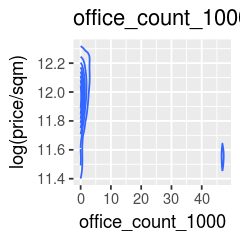

In [105]:
real_estate.trim5= real_estate[real_estate$office_count_1000 <= 10,]
plot.density.2d(real_estate.trim4, real_estate.trim4$office_count_1000, "office_count_1000")

Nope. Update the updated feature list.

|feature             |buckets                                  |
|:-------------------|:----------------------------------------|
|prom_part_1000      |0-20, 20+                                |
|office_km           |0-4, 4+                                  |
|public_healthcare_km|0-4.5, 4.5+                              |
|zd_vokzaly_avto_km  |0-7.5, 7.5-17.5, 17.5+                   |
|big_road1_km        |0-0.8, 0.8-1.5, 1.5-2.5, 2.5-3.75, 3.75+ |
|bulvar_ring_km      |0-5, 5-15, 15+                           |
|mkad_km             |0-4, 4-7.5, 7.5-12.5, 12.5+              |
|metro_km_walk       |0-3, 3+                                  |
|cemetry_km          |0-5, 3+                                  |
|metro_km_avto       |0-3.25, 3.25+                            |
|sub_area            |- Kapotnja, Nekrasovka, Tverskoe, Vnukovo<br>- Hamovniki, Zamoskvorech'e, Hamovniki<br>- everything else                 |
|office_raion        |0-5, 5+                                  |
|product_type        |only has 2 values                        |
|state               |1, 2-3                                   |
|build_year          |1970-1990, 2010-2020, everything else    |

## Next up: columns 51-55

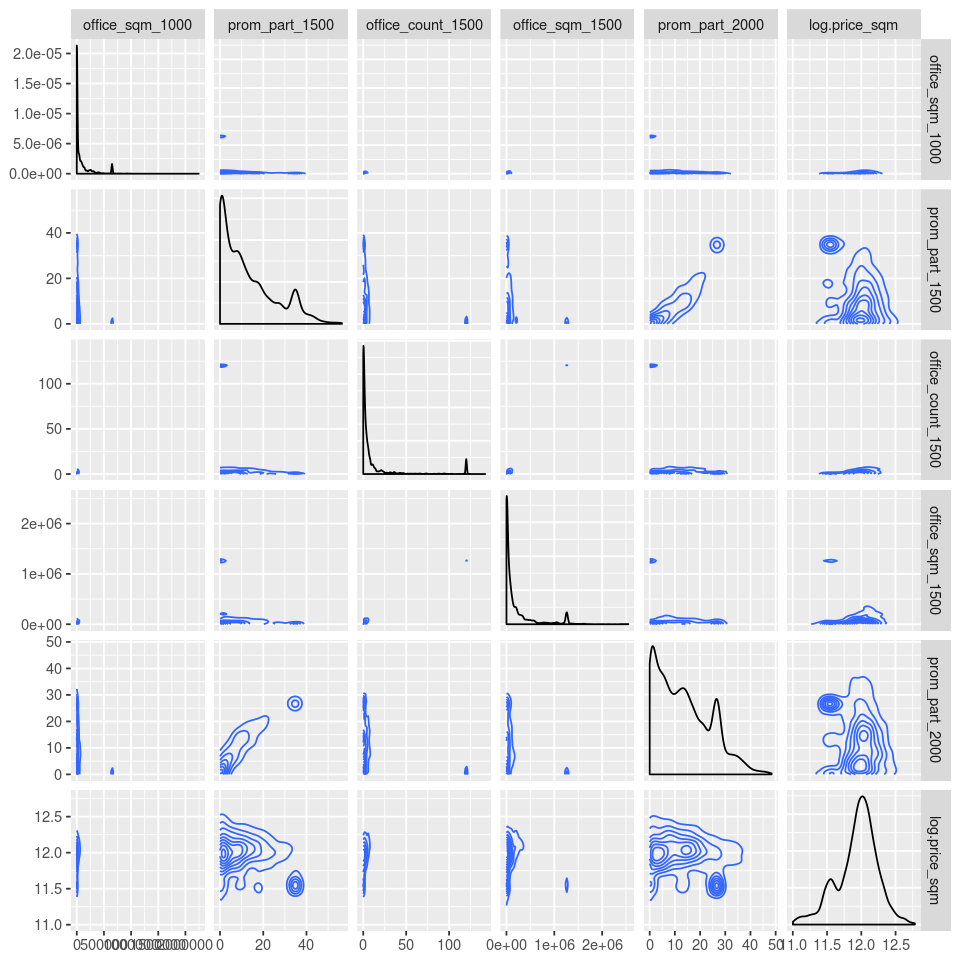

In [19]:
plot.matrix(real_estate, c(51:55,70))

**prom_part_1500** can be split for values on either sideof 30

**prom_part_2000** can be split for values on either sideof 20    

|feature             |buckets                                  |
|:-------------------|:----------------------------------------|
|prom_part_1200      |0-20, 20+                                |
|prom_part_1500      |0-30, 30+                                |
|prom_part_1000      |0-20, 20+                                |
|office_km           |0-4, 4+                                  |
|public_healthcare_km|0-4.5, 4.5+                              |
|zd_vokzaly_avto_km  |0-7.5, 7.5-17.5, 17.5+                   |
|big_road1_km        |0-0.8, 0.8-1.5, 1.5-2.5, 2.5-3.75, 3.75+ |
|bulvar_ring_km      |0-5, 5-15, 15+                           |
|mkad_km             |0-4, 4-7.5, 7.5-12.5, 12.5+              |
|metro_km_walk       |0-3, 3+                                  |
|cemetry_km          |0-5, 3+                                  |
|metro_km_avto       |0-3.25, 3.25+                            |
|sub_area            |- Kapotnja, Nekrasovka, Tverskoe, Vnukovo<br>- Hamovniki, Zamoskvorech'e, Hamovniki<br>- everything else                 |
|office_raion        |0-5, 5+                                  |
|product_type        |only has 2 values                        |
|state               |1, 2-3                                   |
|build_year          |1970-1990, 2010-2020, everything else    |

## Next up: columns 56-60

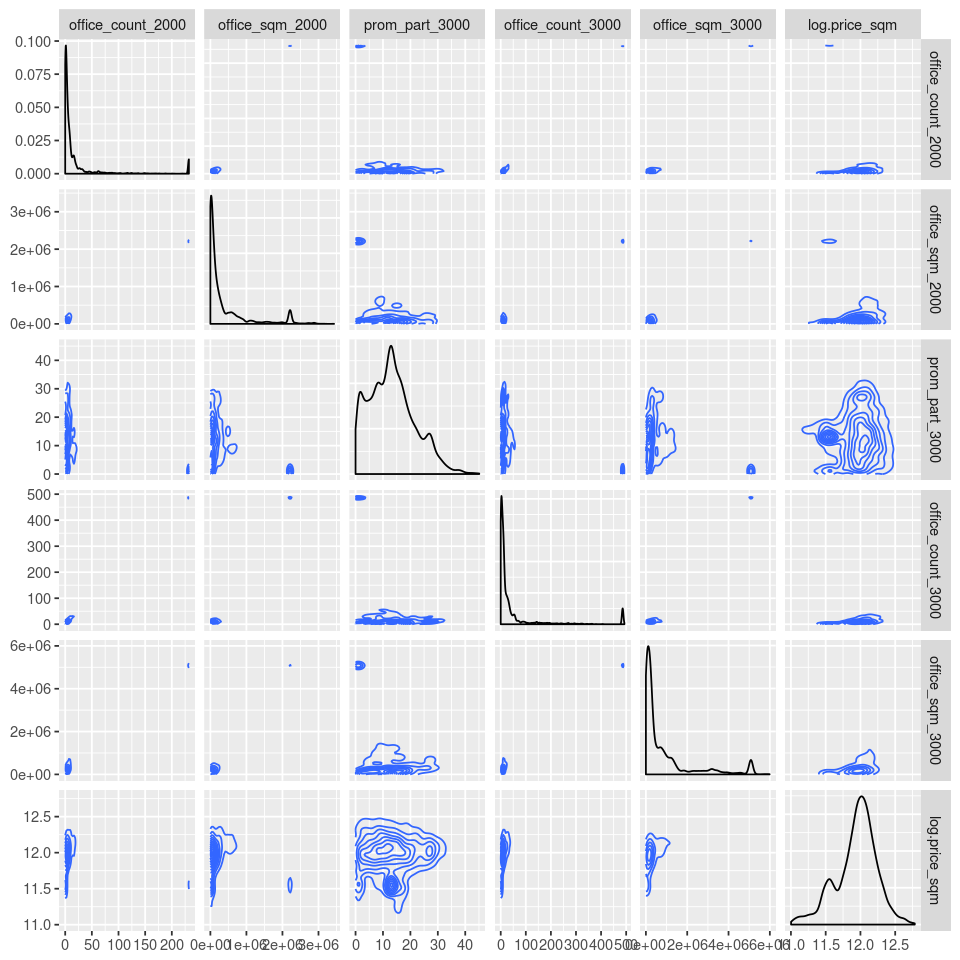

In [20]:
plot.matrix(real_estate, c(56:60,70))

Yet another **prom_part**. Pass.

## Next up: columns 61-65

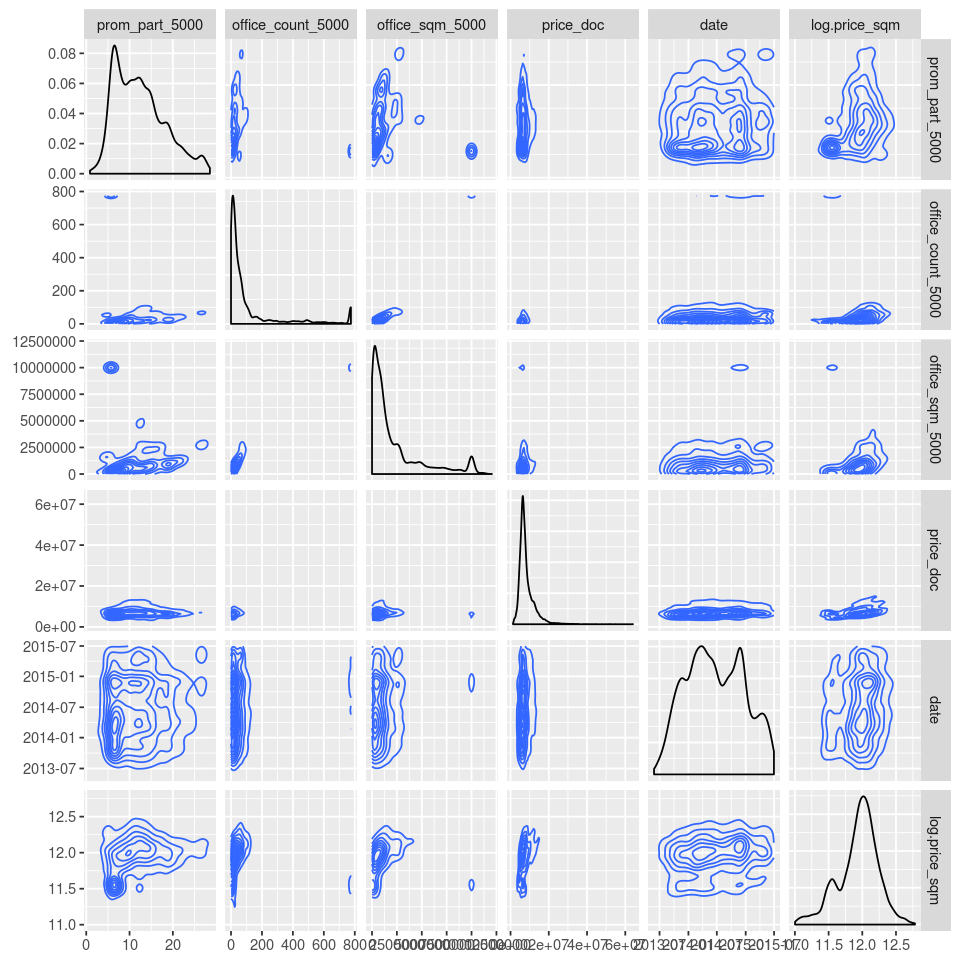

In [21]:
plot.matrix(real_estate, c(61:65,70))

Pretty noisy.  Pass

## Next up: columns 66-69

Warning message:
“Computation failed in `stat_density2d()`:
bandwidths must be strictly positive”Warning message:
“Computation failed in `stat_density2d()`:
bandwidths must be strictly positive”Warning message:
“Computation failed in `stat_density2d()`:
bandwidths must be strictly positive”Warning message:
“Computation failed in `stat_density2d()`:
bandwidths must be strictly positive”Warning message:
“Computation failed in `stat_density2d()`:
bandwidths must be strictly positive”Warning message:
“Computation failed in `stat_density2d()`:
bandwidths must be strictly positive”Warning message:
“Computation failed in `stat_density2d()`:
bandwidths must be strictly positive”Warning message:
“Computation failed in `stat_density2d()`:
bandwidths must be strictly positive”

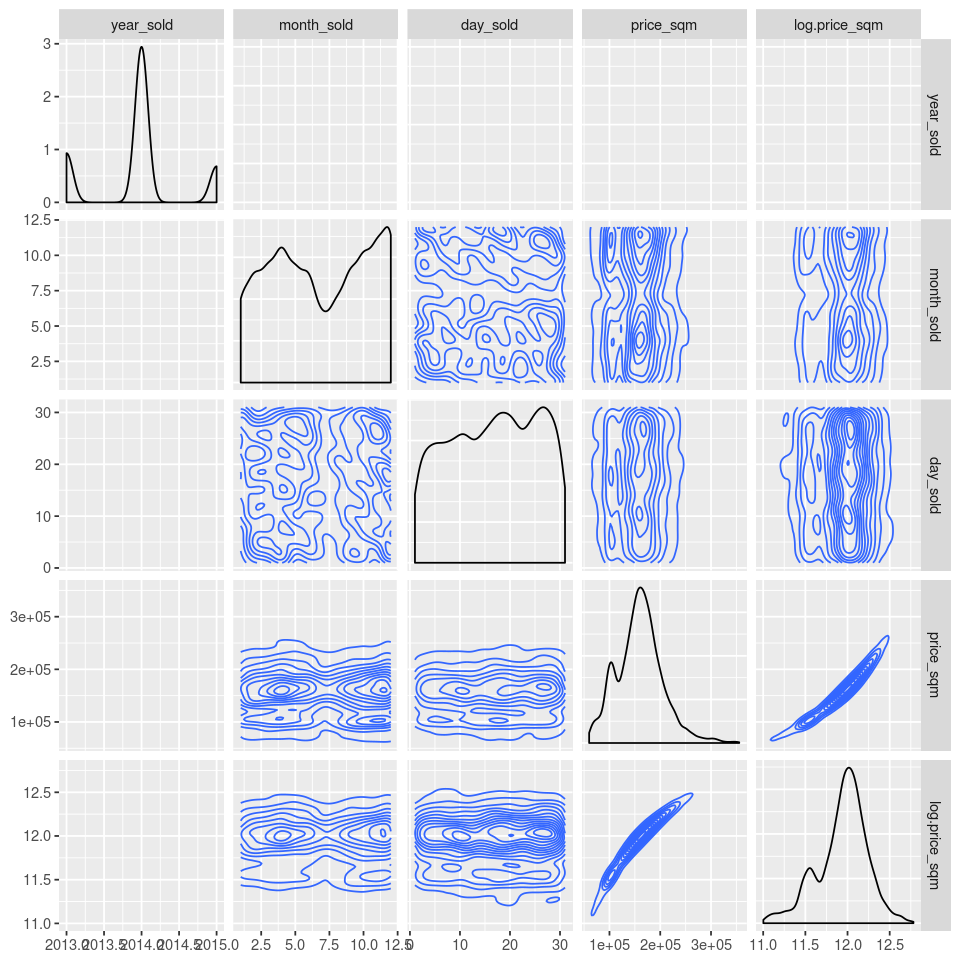

In [22]:
plot.matrix(real_estate, c(66:69,70))

In [ ]:
Full noise, althought we could split by year sold

|feature             |buckets                                  |
|:-------------------|:----------------------------------------|
|year_sold           |keep all existing values              | 
|prom_part_1200      |0-20, 20+                                |
|prom_part_1500      |0-30, 30+                                |
|prom_part_1000      |0-20, 20+                                |
|office_km           |0-4, 4+                                  |
|public_healthcare_km|0-4.5, 4.5+                              |
|zd_vokzaly_avto_km  |0-7.5, 7.5-17.5, 17.5+                   |
|big_road1_km        |0-0.8, 0.8-1.5, 1.5-2.5, 2.5-3.75, 3.75+ |
|bulvar_ring_km      |0-5, 5-15, 15+                           |
|mkad_km             |0-4, 4-7.5, 7.5-12.5, 12.5+              |
|metro_km_walk       |0-3, 3+                                  |
|cemetry_km          |0-5, 3+                                  |
|metro_km_avto       |0-3.25, 3.25+                            |
|sub_area            |- Kapotnja, Nekrasovka, Tverskoe, Vnukovo<br>- Hamovniki, Zamoskvorech'e, Hamovniki<br>- everything else                 |
|office_raion        |0-5, 5+                                  |
|product_type        |only has 2 values                        |
|state               |1, 2-3                                   |
|build_year          |1970-1990, 2010-2020, everything else    |

## Slice, Dice, and Extract

### Things to try
|Try this                            |Result|
|------------------------------------|------|
|Just extract the fields, no binning.|tbd|
|Extract and bin                     |tbd|
|Extract and clever bin              |tbd|

In [ ]:
#### RESUME HERE ####
# change (most of) the everything else's into plus (like row 1 below)
# note, in the case of build_year, it makes sense to keep.
# copy/paste this table,work thru all the scatter plots.

In [ ]:
###  At this point, you hopefully have a decent set of features
### have a go at doing enet with them
### normalize, rexamine if you have to.
### at some point, just bail and turn something in.

In [ ]:
required(dplyr)


### Start with State

In [ ]:
plot.violin(real_estate, real_estate$state, "state")

The violin plot suggests we could have one bucket with state=1, and another with state=2-4.

 Trying a 2d denisity plot ...

In [ ]:
plot.density.2d(real_estate, real_estate$state, "state")

... tells us the same story. Time to start keeping notes:

Bucketizing notes
- **state:** one bucket for state <=1; one for everything else.

### Next up: build year.  
There's going to be lots os possible years, so we'll go straight to the 2d density plot.

In [ ]:
plot.density.2d(real_estate, real_estate$build_year, "build_year")

We're basically looking for ways to draw horizontal lines across the plot to split the contours into "islands."  In this case, you can draw a line at price per sq. m = 11.75. From the vertical point of view, we can get the split we want by separating build year into one bucket for 1970-1990 as well as 2010-2020, and one for everything else.

Update our notes:

Bucketizing notes
- **state:** one bucket for state <=1; one for everything else.
- **build_year:** 
    - one bucket for 1975-1990; 2010-2020
    - one bucket for everything else

### Next up: Kitchen Space, Square Meters.

Try a violin plot.

In [ ]:
plot.violin(real_estate, real_estate$kitch_sq, "kitch_sq")

That's a lot, switch to 2D density plot.

In [ ]:
plot.density.2d(real_estate, real_estate$kitch_sq, "kitch_sq")

Much easier to work with. We can get 2 clean-ish buckets if we split where kitch_sq = 3. Update our ntoes.

Bucketizing notes
- **state:** one bucket for state <=1; one for everything else.
- **build_year:** 
    - one bucket for 1975-1990; 2010-2020
    - one bucket for everything else
- **kitch_sq:** one bucket for kitch_sq <=3; one for everything else.

### Next up: Hospital Beds.
This is another feature with many values, so we'll go to the density plot.'

In [ ]:
plot.violin.vert(real_estate, real_estate$hospital_beds_raion, "hospital_beds_raion")

In [ ]:
plot.density.2d(real_estate, real_estate$hospital_beds_raion, "hospital_beds_raion")

2D Density Notes
- state: split for state = 1; state > 1
- build year:
    - one bucket for 1975-1985; 2007-2020
    - one bucket for everything else 
- kitch_sq: split on <=3; > 3
- hospital_beds_raion (maybe drop this)
    - one bucket for 25-75
    - one bucket for everything else

Violin Notes
- state: split for state = 1; state > 1
- build_year: 
  - one bucket for (1952, 1979, 2013-2015); 
  - one bucket for (1947-1978,  (>1980 and <=2012))
  - one bucket for (1985, 1998-2002, 2016)

In [ ]:
plot.violin.vert(real_estate, real_estate$metro_km_walk, "metro_km_walk")

In [ ]:
plot.density.2d(real_estate, real_estate$metro_km_walk, "metro_km_walk")

2D Density Notes
- state: split for state = 1; state > 1
- build year:
    - one bucket for 1975-1985; 2007-2020
    - one bucket for everything else 
- kitch_sq: split on <=3; > 3
- hospital_beds_raion (maybe drop this)
    - one bucket for 25-75
    - one bucket for everything else
- metro_km_walk
    - split on <=3; > 3

Violin Notes
- state: split for state = 1; state > 1
- build_year: 
  - one bucket for (1952, 1979, 2013-2015); 
  - one bucket for (1947-1978,  (>1980 and <=2012))
  - one bucket for (1985, 1998-2002, 2016)

In [ ]:
plot.violin.vert(real_estate, real_estate$zd_vokzaly_avto_km, "zd_vokzaly_avto_km")

In [ ]:
plot.density.2d(real_estate, real_estate$zd_vokzaly_avto_km, "zd_vokzaly_avto_km")

2D Density Notes
- state: split for state = 1; state > 1
- build year:
    - one bucket for 1975-1985; 2007-2020
    - one bucket for everything else 
- kitch_sq: split on <=3; > 3
- hospital_beds_raion (maybe drop this)
    - one bucket for 25-75
    - one bucket for everything else
- metro_km_walk
    - split on <=3; > 3
- zd_vokzaly_avto_km
    - one bucket for < 7
    - one bucket for 7-20
    - one bucket for > 20

Violin Notes
- state: split for state = 1; state > 1
- build_year: 
  - one bucket for (1952, 1979, 2013-2015); 
  - one bucket for (1947-1978,  (>1980 and <=2012))
  - one bucket for (1985, 1998-2002, 2016)

In [ ]:
plot.violin.vert(real_estate, real_estate$public_healthcare_km, "public_healthcare_km")

In [ ]:
plot.density.2d(real_estate, real_estate$public_healthcare_km, "public_healthcare_km")

2D Density Notes
- public_healthcare_km
    - one bucket for > 5
    - one bucket for 2-5
    - one ucket for < 2
- state: split for state = 1; state > 1
- build year:
    - one bucket for 1975-1985; 2007-2020
    - one bucket for everything else 
- kitch_sq: split on <=3; > 3
- hospital_beds_raion (maybe drop this)
    - one bucket for 25-75
    - one bucket for everything else
- metro_km_walk
    - split on <=3; > 3
- zd_vokzaly_avto_km
    - one bucket for < 7
    - one bucket for 7-20
    - one bucket for > 20

Violin Notes
- state: split for state = 1; state > 1
- build_year: 
  - one bucket for (1952, 1979, 2013-2015); 
  - one bucket for (1947-1978,  (>1980 and <=2012))
  - one bucket for (1985, 1998-2002, 2016)

In [ ]:
plot.violin(real_estate, real_estate$prom_part_1500, "prom_part_1500")

In [ ]:
plot.density.2d(real_estate, real_estate$prom_part_1500, "prom_part_1500")

2D Density Notes
- prom_part_1500
    - one bucket for < 5
    - one bucket for 5-30
    - one bucket for > 30
- public_healthcare_km
    - one bucket for > 5
    - one bucket for 2-5
    - one ucket for < 2
- state: split for state = 1; state > 1
- build year:
    - one bucket for 1975-1985; 2007-2020
    - one bucket for everything else 
- kitch_sq: split on <=3; > 3
- hospital_beds_raion (maybe drop this)
    - one bucket for 25-75
    - one bucket for everything else
- metro_km_walk
    - split on <=3; > 3
- zd_vokzaly_avto_km
    - one bucket for < 7
    - one bucket for 7-20
    - one bucket for > 20

Violin Notes
- state: split for state = 1; state > 1
- build_year: 
  - one bucket for (1952, 1979, 2013-2015); 
  - one bucket for (1947-1978,  (>1980 and <=2012))
  - one bucket for (1985, 1998-2002, 2016)

In [ ]:
plot.violin(real_estate, real_estate$material, "material")

In [ ]:
plot.density.2d(real_estate, real_estate$material, "material")

2D Density Notes
- prom_part_1500
    - one bucket for < 5
    - one bucket for 5-30
    - one bucket for > 30
- public_healthcare_km
    - one bucket for > 5
    - one bucket for 2-5
    - one ucket for < 2
- state: split for state = 1; state > 1
- build year:
    - one bucket for 1975-1985; 2007-2020
    - one bucket for everything else 
- kitch_sq: split on <=3; > 3
- hospital_beds_raion (maybe drop this)
    - one bucket for 25-75
    - one bucket for everything else
- metro_km_walk
    - split on <=3; > 3
- zd_vokzaly_avto_km
    - one bucket for < 7
    - one bucket for 7-20
    - one bucket for > 20

Violin Notes
- state: split for state = 1; state > 1
- build_year: 
  - one bucket for (1952, 1979, 2013-2015); 
  - one bucket for (1947-1978,  (>1980 and <=2012))
  - one bucket for (1985, 1998-2002, 2016)

In [ ]:
plot.violin(real_estate, real_estate$num_room, "num_room")

In [ ]:
plot.density.2d(real_estate, real_estate$num_room, "num_room")

2D Density Notes
- prom_part_1500
    - one bucket for < 5
    - one bucket for 5-30
    - one bucket for > 30
- public_healthcare_km
    - one bucket for > 5
    - one bucket for 2-5
    - one ucket for < 2
- state: split for state = 1; state > 1
- build year:
    - one bucket for 1975-1985; 2007-2020
    - one bucket for everything else 
- kitch_sq: split on <=3; > 3
- hospital_beds_raion (maybe drop this)
    - one bucket for 25-75
    - one bucket for everything else
- metro_km_walk
    - split on <=3; > 3
- zd_vokzaly_avto_km
    - one bucket for < 7
    - one bucket for 7-20
    - one bucket for > 20

Violin Notes
- state: split for state = 1; state > 1
- build_year: 
  - one bucket for (1952, 1979, 2013-2015); 
  - one bucket for (1947-1978,  (>1980 and <=2012))
  - one bucket for (1985, 1998-2002, 2016)

In [ ]:
plot.violin(real_estate, real_estate$healthcare_centers_raion, "healthcare_centers_raion")

In [ ]:
plot.density.2d(real_estate, real_estate$healthcare_centers_raion, "healthcare_centers_raion")

2D Density Notes
- prom_part_1500
    - one bucket for < 5
    - one bucket for 5-30
    - one bucket for > 30
- public_healthcare_km
    - one bucket for > 5
    - one bucket for 2-5
    - one ucket for < 2
- state: split for state = 1; state > 1
- build year:
    - one bucket for 1975-1985; 2007-2020
    - one bucket for everything else 
- kitch_sq: split on <=3; > 3
- hospital_beds_raion (maybe drop this)
    - one bucket for 25-75
    - one bucket for everything else
- metro_km_walk
    - split on <=3; > 3
- zd_vokzaly_avto_km
    - one bucket for < 7
    - one bucket for 7-20
    - one bucket for > 20

Violin Notes
- state: split for state = 1; state > 1
- build_year: 
  - one bucket for (1952, 1979, 2013-2015); 
  - one bucket for (1947-1978,  (>1980 and <=2012))
  - one bucket for (1985, 1998-2002, 2016)

In [ ]:
plot.violin(real_estate, real_estate$year_sold, "year_sold")

In [ ]:
plot.density.2d(real_estate, real_estate$year_sold, "year_sold")

2D Density Notes
- prom_part_1500
    - one bucket for < 5
    - one bucket for 5-30
    - one bucket for > 30
- public_healthcare_km
    - one bucket for > 5
    - one bucket for 2-5
    - one ucket for < 2
- state: split for state = 1; state > 1
- build year:
    - one bucket for 1975-1985; 2007-2020
    - one bucket for everything else 
- kitch_sq: split on <=3; > 3
- hospital_beds_raion (maybe drop this)
    - one bucket for 25-75
    - one bucket for everything else
- metro_km_walk
    - split on <=3; > 3
- zd_vokzaly_avto_km
    - one bucket for < 7
    - one bucket for 7-20
    - one bucket for > 20

Violin Notes
- state: split for state = 1; state > 1
- build_year: 
  - one bucket for (1952, 1979, 2013-2015); 
  - one bucket for (1947-1978,  (>1980 and <=2012))
  - one bucket for (1985, 1998-2002, 2016)

In [ ]:
plot.violin(real_estate, real_estate$month_sold, "month_sold")

In [ ]:
plot.density.2d(real_estate, real_estate$month_sold, "month_sold")

2D Density Notes
- prom_part_1500
    - one bucket for < 5
    - one bucket for 5-30
    - one bucket for > 30
- public_healthcare_km
    - one bucket for > 5
    - one bucket for 2-5
    - one ucket for < 2
- state: split for state = 1; state > 1
- build year:
    - one bucket for 1975-1985; 2007-2020
    - one bucket for everything else 
- kitch_sq: split on <=3; > 3
- hospital_beds_raion (maybe drop this)
    - one bucket for 25-75
    - one bucket for everything else
- metro_km_walk
    - split on <=3; > 3
- zd_vokzaly_avto_km
    - one bucket for < 7
    - one bucket for 7-20
    - one bucket for > 20

Violin Notes
- state: split for state = 1; state > 1
- build_year: 
  - one bucket for (1952, 1979, 2013-2015); 
  - one bucket for (1947-1978,  (>1980 and <=2012))
  - one bucket for (1985, 1998-2002, 2016)

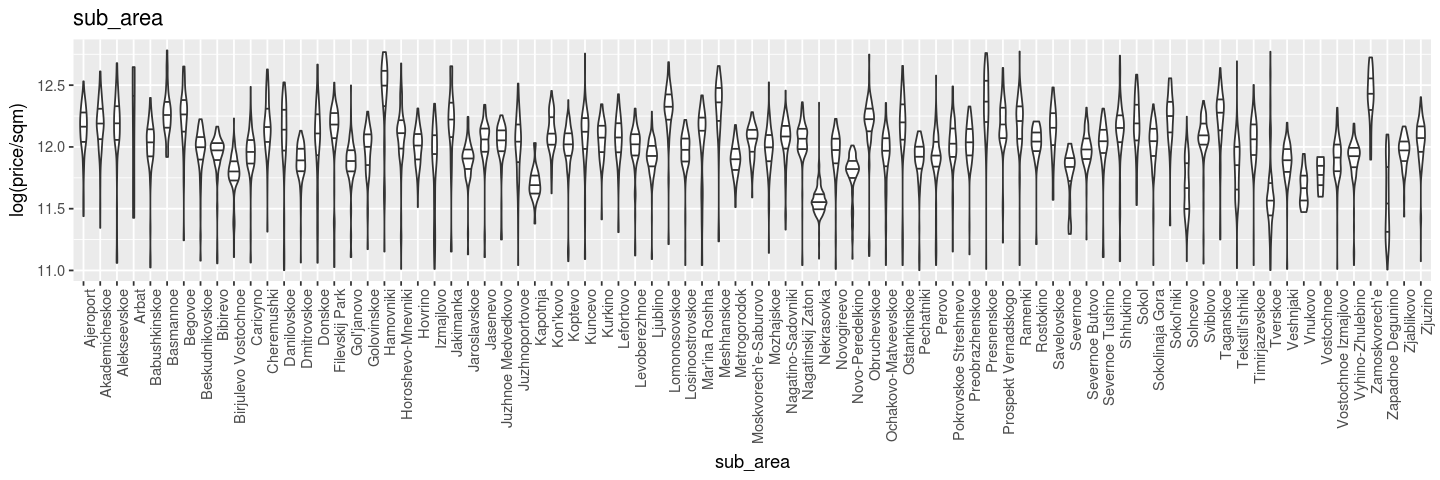

In [47]:
plot.violin.vert(real_estate, real_estate$sub_area, "sub_area")

Warning message:
“Computation failed in `stat_density2d()`:
bandwidths must be strictly positive”

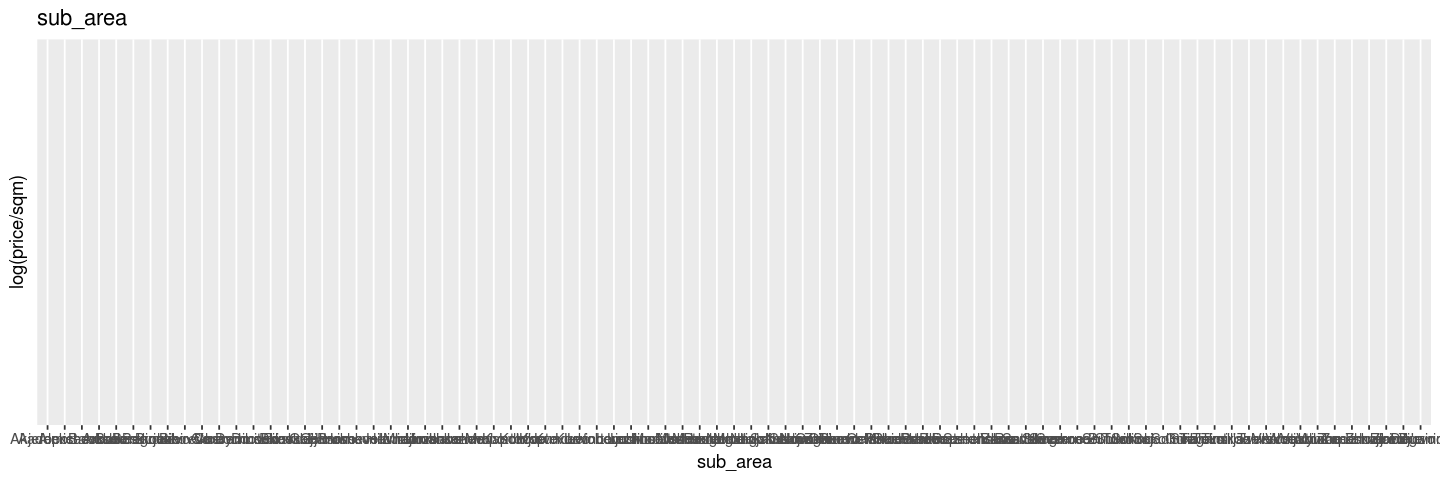

In [48]:
plot.density.2d(real_estate, real_estate$sub_area, "sub_area")

2D Density Notes
- prom_part_1500
    - one bucket for < 5
    - one bucket for 5-30
    - one bucket for > 30
- public_healthcare_km
    - one bucket for > 5
    - one bucket for 2-5
    - one ucket for < 2
- state: split for state = 1; state > 1
- build year:
    - one bucket for 1975-1985; 2007-2020
    - one bucket for everything else 
- kitch_sq: split on <=3; > 3
- hospital_beds_raion (maybe drop this)
    - one bucket for 25-75
    - one bucket for everything else
- metro_km_walk
    - split on <=3; > 3
- zd_vokzaly_avto_km
    - one bucket for < 7
    - one bucket for 7-20
    - one bucket for > 20

Violin Notes
- state: split for state = 1; state > 1
- build_year: 
  - one bucket for (1952, 1979, 2013-2015); 
  - one bucket for (1947-1978,  (>1980 and <=2012))
  - one bucket for (1985, 1998-2002, 2016)
- **sub_area: split on (violin only)**
  - Kapotnja, Nekrasovka, Tverskoe, Vnukovo
  - Hamovniki, Zamoskvorech'e, Hamovniki
   - everything else 

## We've got our Buckets, now let's extract

In [ ]:
#This hould sbe movde
real_estate$century = ifelse(real_estate$build_year < 2000, 20, 21)

In [ ]:
real_estate$year_buckets = 
    ifelse(real_estate$build_year < 1979 1, 1, 0)
real_estate$year_buckets = 
    ifelse((real_estate$build_year == 1979 1) & 
           (real_estate$year_buckets == 0), 
           2, 0)
real_estate$year_buckets = 
    ifelse((real_estate$build_year == 1979 1) & 
           (real_estate$year_buckets == 0), 
           2, 0)


In [ ]:
#This should be move
real_estate$state_buckets = ifelse(real_estate$state == 1, 1, 2)



real_estate$two_kitch = ifelse(real_estate$kitch_sq == 1, 1, 2)


## Try some ANOVA

doesn't work
- state
- material


In [ ]:
real_estate.aov = aov(log.price_sqm ~ year_sold, data = real_estate)
summary(real_estate.aov)
options(repr.plot.width=4, repr.plot.height=6)

boxplot(real_estate$log.price_sqm ~ real_estate$year_sold)

## Try some Tukey HSD

In [ ]:
real_estate.hsd = TukeyHSD(real_estate.aov)
real_estate.hsd
options(repr.plot.width=8, repr.plot.height=3)
par (las=2)
par(mar=c(5,10,3,1))
plot(real_estate.hsd)

## Apply a bit of Domain Knowledge
Review the fiends in the dataset

In [ ]:
str(real_estate)

In [ ]:
options(repr.plot.width=12, repr.plot.height=12)
ggplot(real_estate, aes(sub_area)) + geom_bar() + coord_flip()

- max_floor less than 10
- one neightborhood Nekrasovka
- built in the 21st century
df[grep("eta", df$Title),]

In [ ]:
areas = c("Nekrasovka")
real_estate.subset = real_estate[grep("Nekrasovka", real_estate$sub_area),]
dim(real_estate)
dim(real_estate.subset)
head(real_estate.subset, 3)
real_estate = real_esate.subset

### Price vs. year built, sliced by Year sold, Rooms, Healthcare centers 

In [ ]:
options(repr.plot.width=12, repr.plot.height=16)
ggplot(real_estate, aes(build_year, log.price_sqm)) +
facet_grid(material ~ state) +
geom_point(aes(color = factor(num_room), 
           size = healthcare_centers_raion,
          shape = factor(year_sold)), 
          alpha = 0.3) +
ggtitle('Relationship between build year and Price, 
  \n faceted by state (columns), and material (rows),
  \n sliced by rooms(color), healthcare centers (size), year sold (shape)')

Seems like we can split by "century" -- properties built in the 1900's vs 2000's

### Price vs. Vokzly, sliced by Year sold, Material, Healthcare centers 

In [ ]:
options(repr.plot.width=12, repr.plot.height=16)
ggplot(real_estate, aes(zd_vokzaly_avto_km, log.price_sqm)) +
facet_grid(material ~ state) +
geom_point(aes(color = factor(month_sold), 
           size = healthcare_centers_raion,
          shape = factor(year_sold)), 
          alpha = 0.3) +
ggtitle('Relationship between build year and Price, 
  \n faceted by state (columns), and material (rows),
  \n sliced by month_sold(color), healthcare centers (size), year sold (shape)')

In [ ]:
options(repr.plot.width=12, repr.plot.height=16)
ggplot(real_estate, aes(full_sq, log.price_sqm)) +
facet_grid(material ~ state) +
geom_point(aes(color = factor(month_sold), 
           size = healthcare_centers_raion,
          shape = factor(year_sold)), 
          alpha = 0.3) +
ggtitle('Relationship between total floorspace and Price, 
  \n faceted by state (columns), and material (rows),
  \n sliced by month_sold(color), healthcare centers (size), year sold (shape)')

Some linear patters for log(Price)<11;  material in {1,2, 5}; state in {2,3}

In [ ]:
# real_estate.subset = subset(real_estate, log.price_sqm<=11 & 
#                            material==5  & state == 3 & build_year < 2000)
real_estate.subset = subset(real_estate,  
                            build_year < 2000)
dim(real_estate)
dim(real_estate.subset)
head(real_estate.subset,3)

In [ ]:
ggplot(real_estate.subset, aes(x = log.price_sqm, y = full_sq,))+ 
geom_point(aes(color = factor(state),
               size = date),
               alpha = 0.3) + 
geom_density2d() +
xlab('log(Price Per Sq Meter)') + 
ylab('Foor space') + 
ggtitle('Price and Floor Space')

## Prune Fields

So far ...
- Potential numerics: 8
    - state
    - build_year
    - kitch_sq
    - hospital_beds_raion
    - metro_km_walk
    - zd_vokzaly_avto_km
    - public_healthcare_km
    - office_km
    - prom_part_1500
- Potential categoricals: 5
  - material (5 values)
  - num_room (5 values)
  - healthcare_centers_raion (7 values)
  - year_sold (3 values)
  - month_sold (12 values)

In [ ]:
keeps = c(
     'build_year',
     'kitch_sq',
     'hospital_beds_raion',
     'metro_km_walk',
     'zd_vokzaly_avto_km',
     'public_healthcare_km',
     'office_km',
     'prom_part_1500',
     'full_sq',
     'num_room',
     'healthcare_centers_raion',
     'year_sold',
     'month_sold',

 'log.price_sqm'
)

real_estate.subset = real_estate.subset[,(names(real_estate.subset) %in% keeps)]
dim(real_estate.subset)
head(real_estate.subset)

# Analysis

## Elastic Net

In [ ]:
real_estate.scaled = real_estate.subset
head(real_estate.scaled, 3)
dim(real_estate.scaled)

In [ ]:
keeps

In [ ]:
real_estate.scaled[, keeps] = 
    lapply(real_estate.scaled[, keeps],scale)
real_estate.scaled = real_estate.scaled[,(names(real_estate.scaled) %in% keeps)]
head(real_estate.scaled, 3)
dim(real_estate.scaled)

In [ ]:
mod.mat = model.matrix(log.price_sqm ~ . -1, data = real_estate.scaled)
head(mod.mat)
dim(mod.mat)
range(mod.mat)

## SVD Stuff

In [ ]:
svdM = svd(mod.mat)
d = svdM$d
plot(log(d))

### Helper Funcitons

In [ ]:
require(repr)
options(repr.plot.width=8, repr.plot.height=4)

plot.svd.reg <- function(df, k = 4){
  require(ggplot2)
  require(gridExtra)
  
  p1 <- ggplot(df) + 
            geom_point(aes(score, resids), size = 2) + 
            stat_smooth(aes(score, resids)) +
            ggtitle('Residuals vs. fitted values')
 
  p2 <- ggplot(df, aes(resids)) +
           geom_histogram(aes(y = ..density..)) +
           geom_density(color = 'red', fill = 'red', alpha = 0.2) +
           ggtitle('Histogram of residuals')

  qqnorm(df$resids)
    
  grid.arrange(p1, p2, ncol = 2)
    
  df$std.resids = sqrt((df$resids - mean(df$resids))^2)  
    
  p3 = ggplot(df) + 
            geom_point(aes(score, std.resids), size = 2) + 
            stat_smooth(aes(score, std.resids)) +
            ggtitle('Standardized residuals vs. fitted values')
  print(p3) 
    
  n = nrow(df)
  Ybar = mean(df$logPrice)
  SST <- sum((df$logPrice - Ybar)^2)
  SSR <- sum(df$resids * df$resids)
  SSE = SST - SSR
  cat(paste('SSE =', as.character(SSE), '\n'))
  cat(paste('SSR =', as.character(SSR), '\n'))
  cat(paste('SST =', as.character(SSE + SSR), '\n'))
  cat(paste('RMSE =', as.character(SSE/(n - 2)), '\n'))

  adjR2  <- 1.0 - (SSR/SST) * ((n - 1)/(n - k - 1))
  cat(paste('Adjusted R^2 =', as.character(adjR2)), '\n')
}

In [ ]:
require(glmnet)
b = as.matrix(real_estate.scaled$log.price_sqm) #must be matrix, NOT dataframe
mod.lasso = glmnet(mod.mat, b, family = 'gaussian', nlambda = 100, alpha = 0.5)
real_estate.enet = real_estate.scaled
real_estate.enet$score = predict(mod.lasso, newx = mod.mat)[, 15]
real_estate.enet$resids = real_estate.enet$score - real_estate.enet$log.price_sqm
plot.svd.reg(real_estate.enet)

In [ ]:
plot(mod.lasso, xvar = 'lambda', label = TRUE)

In [ ]:
plot(mod.lasso, xvar = 'dev', label = TRUE)

In [ ]:
print(mod.lasso)

**Df of 71 corrsponds to lambda of 0.0004207 (row 71). Taking the log ...**

In [ ]:
log(0.0004207)

... which puts us on a reasonable part of the coefficents plot, about halfway between 0 and -2. Time to evaluate. First, a helper function. [CHECK hits]

In [ ]:
try.lambda = function(svdM, lambda, M1, M2, V2) {
    d.trim = 1/ (svdM$d + lambda)
    mD = diag(d.trim)
    mInv = svdM$v %*% mD %*% t(svdM$u)
    b2 = mInv %*% V2
    M1$score = M2 %*% b2 + mean(V2)
    M1$resids = M1$score - V2
    plot.svd.reg(M1)
}

**Try the lambda.**

In [ ]:
svdM = svd(mod.mat)

In [ ]:
try.lambda(svdM, 0.0004207, real_estate.enet, mod.mat, real_estate.enet$log.price_sqm)